# wine2

# 데이터 로드

### 패키지

In [1]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so


# statistics
import statsmodels.api as sm

# pandas options
pd.set_option("mode.copy_on_write", False) # pandas 2.0.0 이상
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 8

import sklearn

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [2]:
wine = pd.read_csv("C:/Users/zezeg/Desktop/Wine_quality.csv")
wine1 = wine.copy()

# 전처리

## 이상치 변환

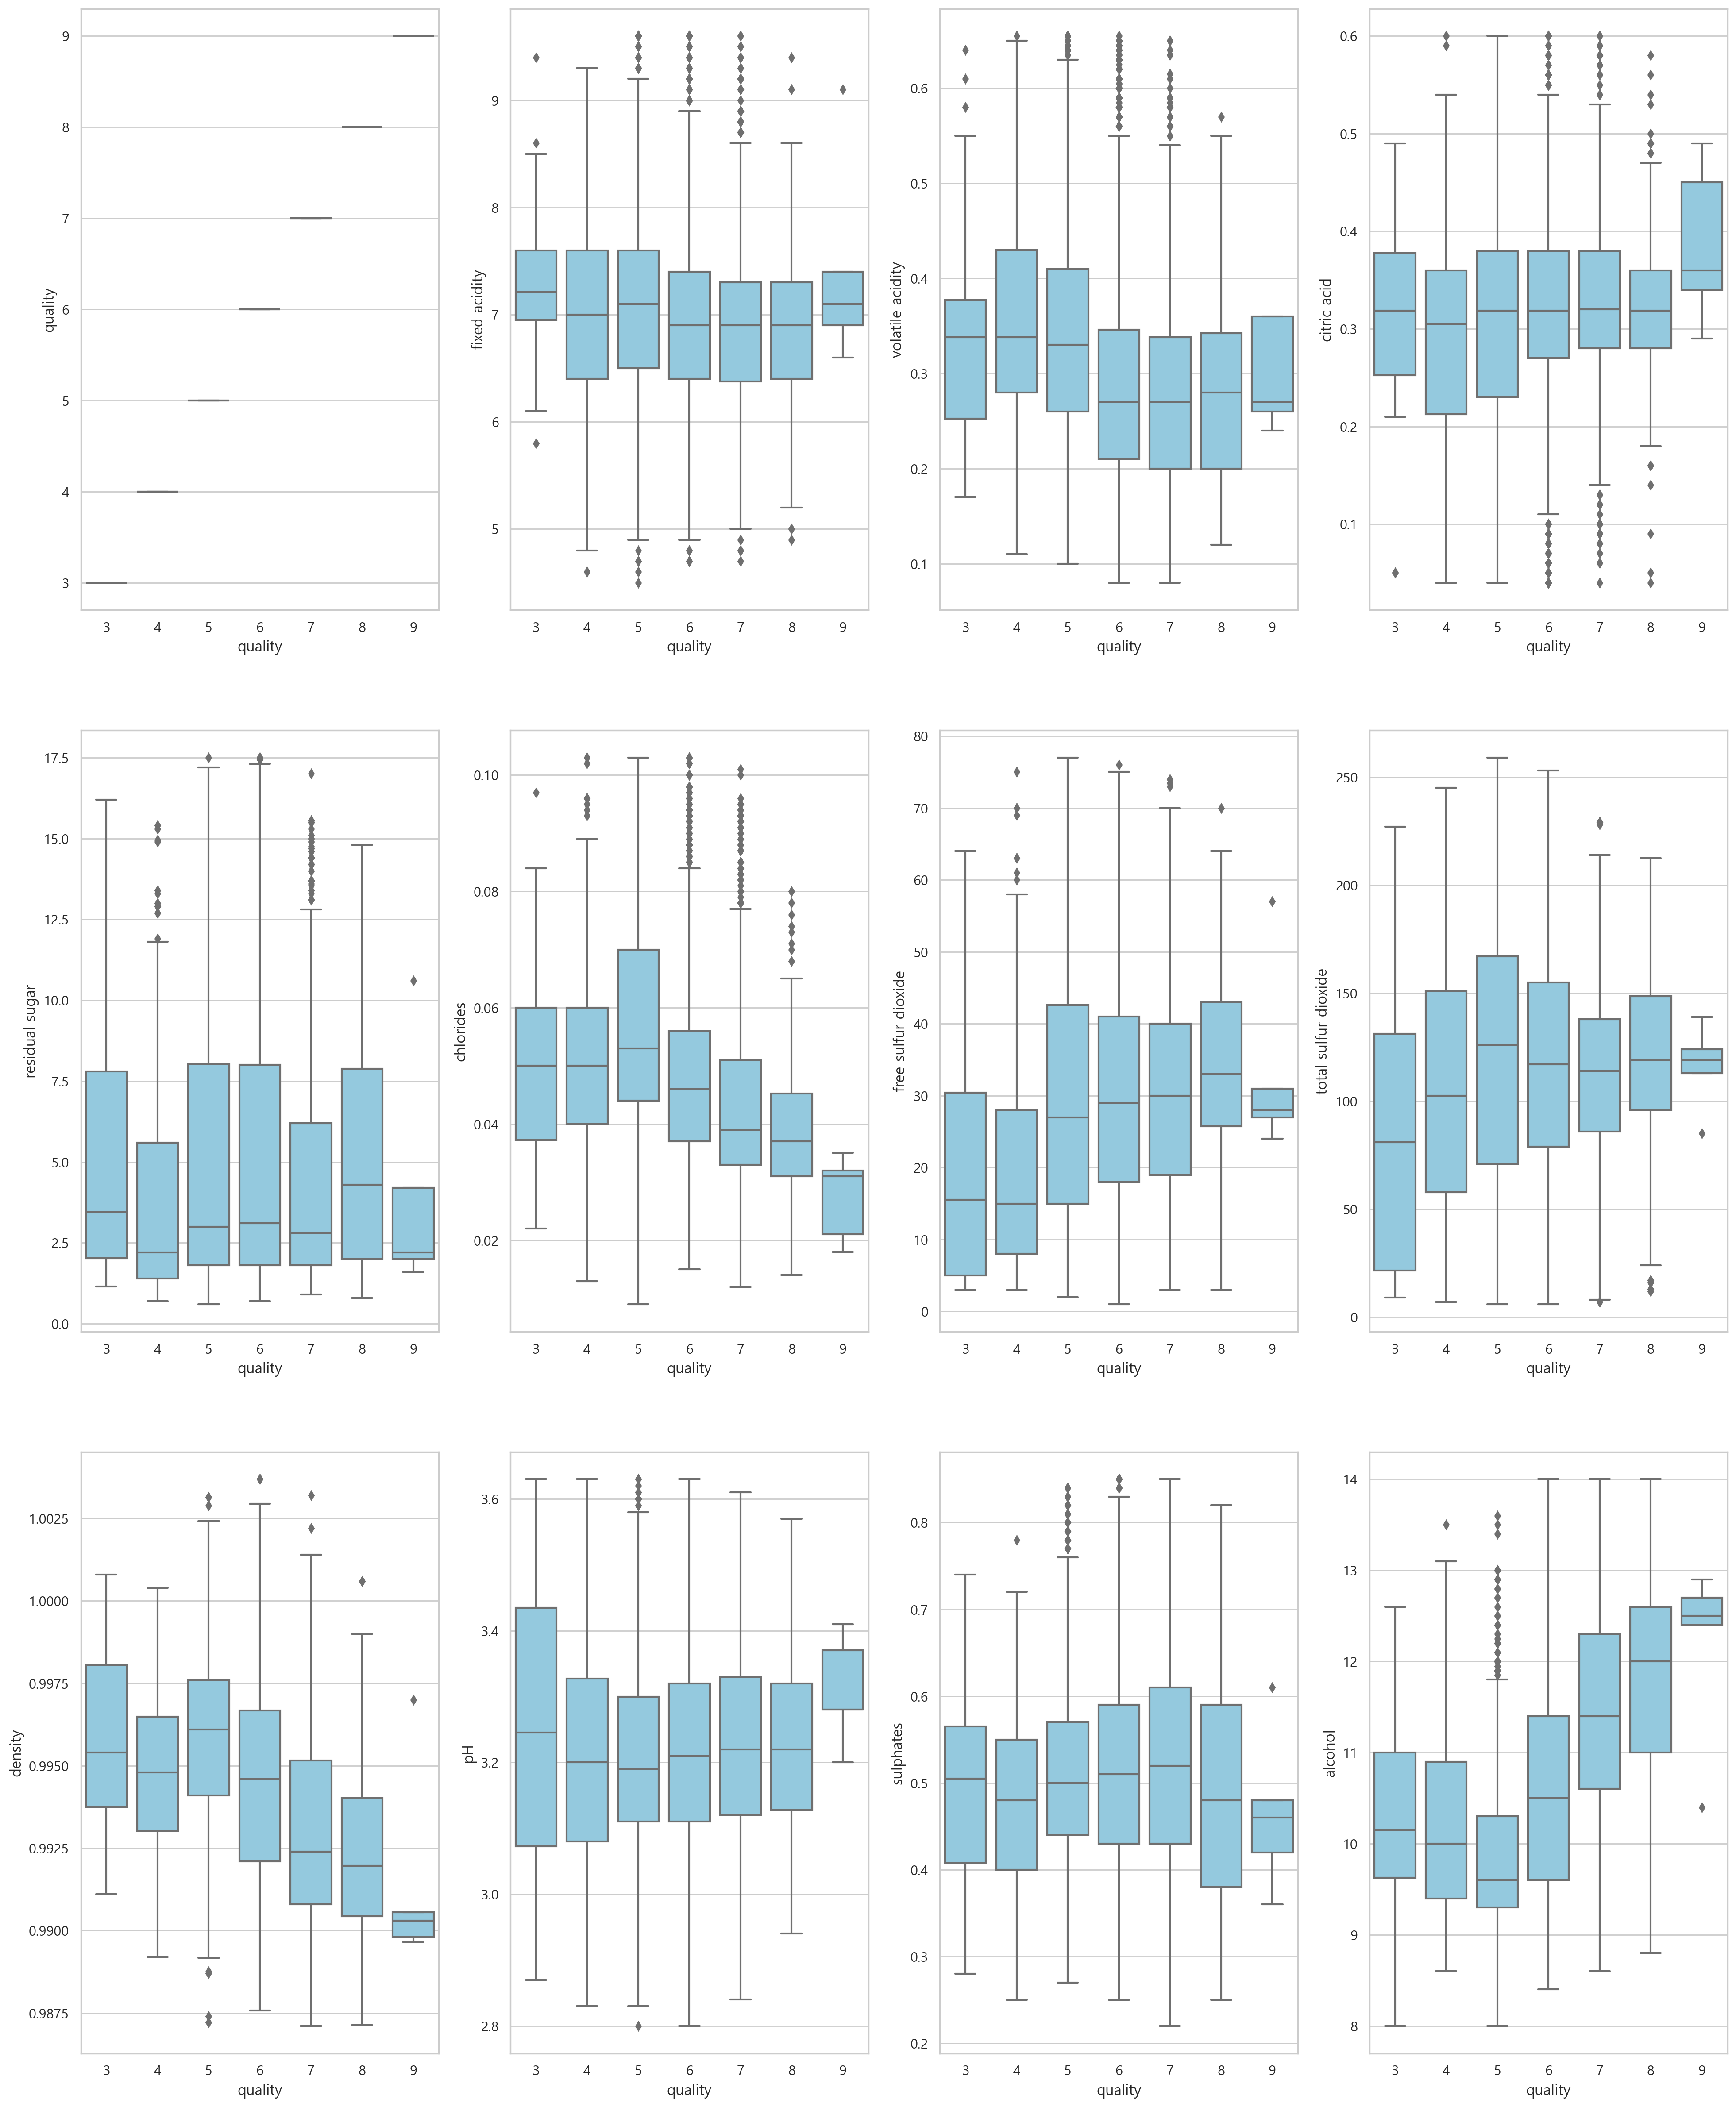

In [3]:
# 이상치 변환
wine1 = wine1.drop(columns="index")
wine1_imputation_mean=wine1.copy()


# 박스 플롯 함수 정의
def plot_boxplot(data, column, title):
    sns.boxplot(data[column])
    plt.title(title)
    plt.show()

# 대체할 열 목록
columns_to_impute = wine1_imputation_mean.columns.drop(['quality','type'])

# 평균 대체
for column in columns_to_impute:

    # q1- 1.5 iqr, q3 + 1.5 iqr 기준으로 이상치 정의
    q1 = wine1_imputation_mean[column].quantile(0.25)
    q3 = wine1_imputation_mean[column].quantile(0.75)
    iqr = q3 - q1
    lower_tail = q1 - 1.5 * iqr
    upper_tail = q3 + 1.5 * iqr
    mean_value = wine1_imputation_mean[column].mean()
    
    wine1_imputation_mean[column] = np.where((wine1_imputation_mean[column] > upper_tail) | (wine1_imputation_mean[column] < lower_tail), mean_value, wine1_imputation_mean[column])


# boxplot
sns.set(style="whitegrid")
plt.rc('font', family='Malgun Gothic')
fig, ax1 = plt.subplots(3, 4, figsize=(24, 30))
columns = list(wine1_imputation_mean.columns)

k = 0
for i in range(3):
    for j in range(4):
        sns.boxplot(x='quality', y=columns[k], data=wine1_imputation_mean, ax=ax1[i][j], color='skyblue')
        k += 1
plt.show()

In [4]:
a = wine1_imputation_mean["quality"].value_counts().reset_index()
sum = a["count"].sum()

In [5]:
a["ratio"] = a["count"] / sum

a

# 너무 불균형한 데이터셋임. 3,4,8,9는 서로 합치는 것을 고려해 볼 것


quality  count  ratio
0        6   2416   0.44
1        5   1788   0.33
2        7    924   0.17
3        4    186   0.03
4        8    152   0.03
5        3     26   0.00
6        9      5   0.00

In [6]:
# 너무 값이 많이 차이나는 9클래스와 3클래스를 각각 8과 4로 합병

wine1_imputation_mean.loc[wine1_imputation_mean['quality'].isin([3, 4]), 'quality'] = 4
wine1_imputation_mean.loc[wine1_imputation_mean['quality'].isin([8, 9]), 'quality'] = 8

wine1_imputation_mean["quality"].value_counts()


quality
6    2416
5    1788
7     924
4     212
8     157
Name: count, dtype: int64

## trainset /testset 분리

In [25]:
wine11 = wine1_imputation_mean.copy()


from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(wine11, test_size = 0.2, random_state=42, stratify = wine11["quality"])


train_set, valid_set = train_test_split(strat_train_set, test_size = 0.2, random_state=42, stratify = strat_train_set["quality"])


In [26]:
# train set 
trainset = train_set.drop("quality", axis = 1)
trainset_labels = train_set["quality"].copy()

validset = valid_set.drop("quality", axis = 1)
validset_labels = valid_set["quality"].copy()

# test set 1
testset = strat_test_set.drop("quality", axis = 1)
testset_labels = strat_test_set["quality"].copy()

## 전처리 파이프라인

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer # for boxcox
from scipy.stats import boxcox


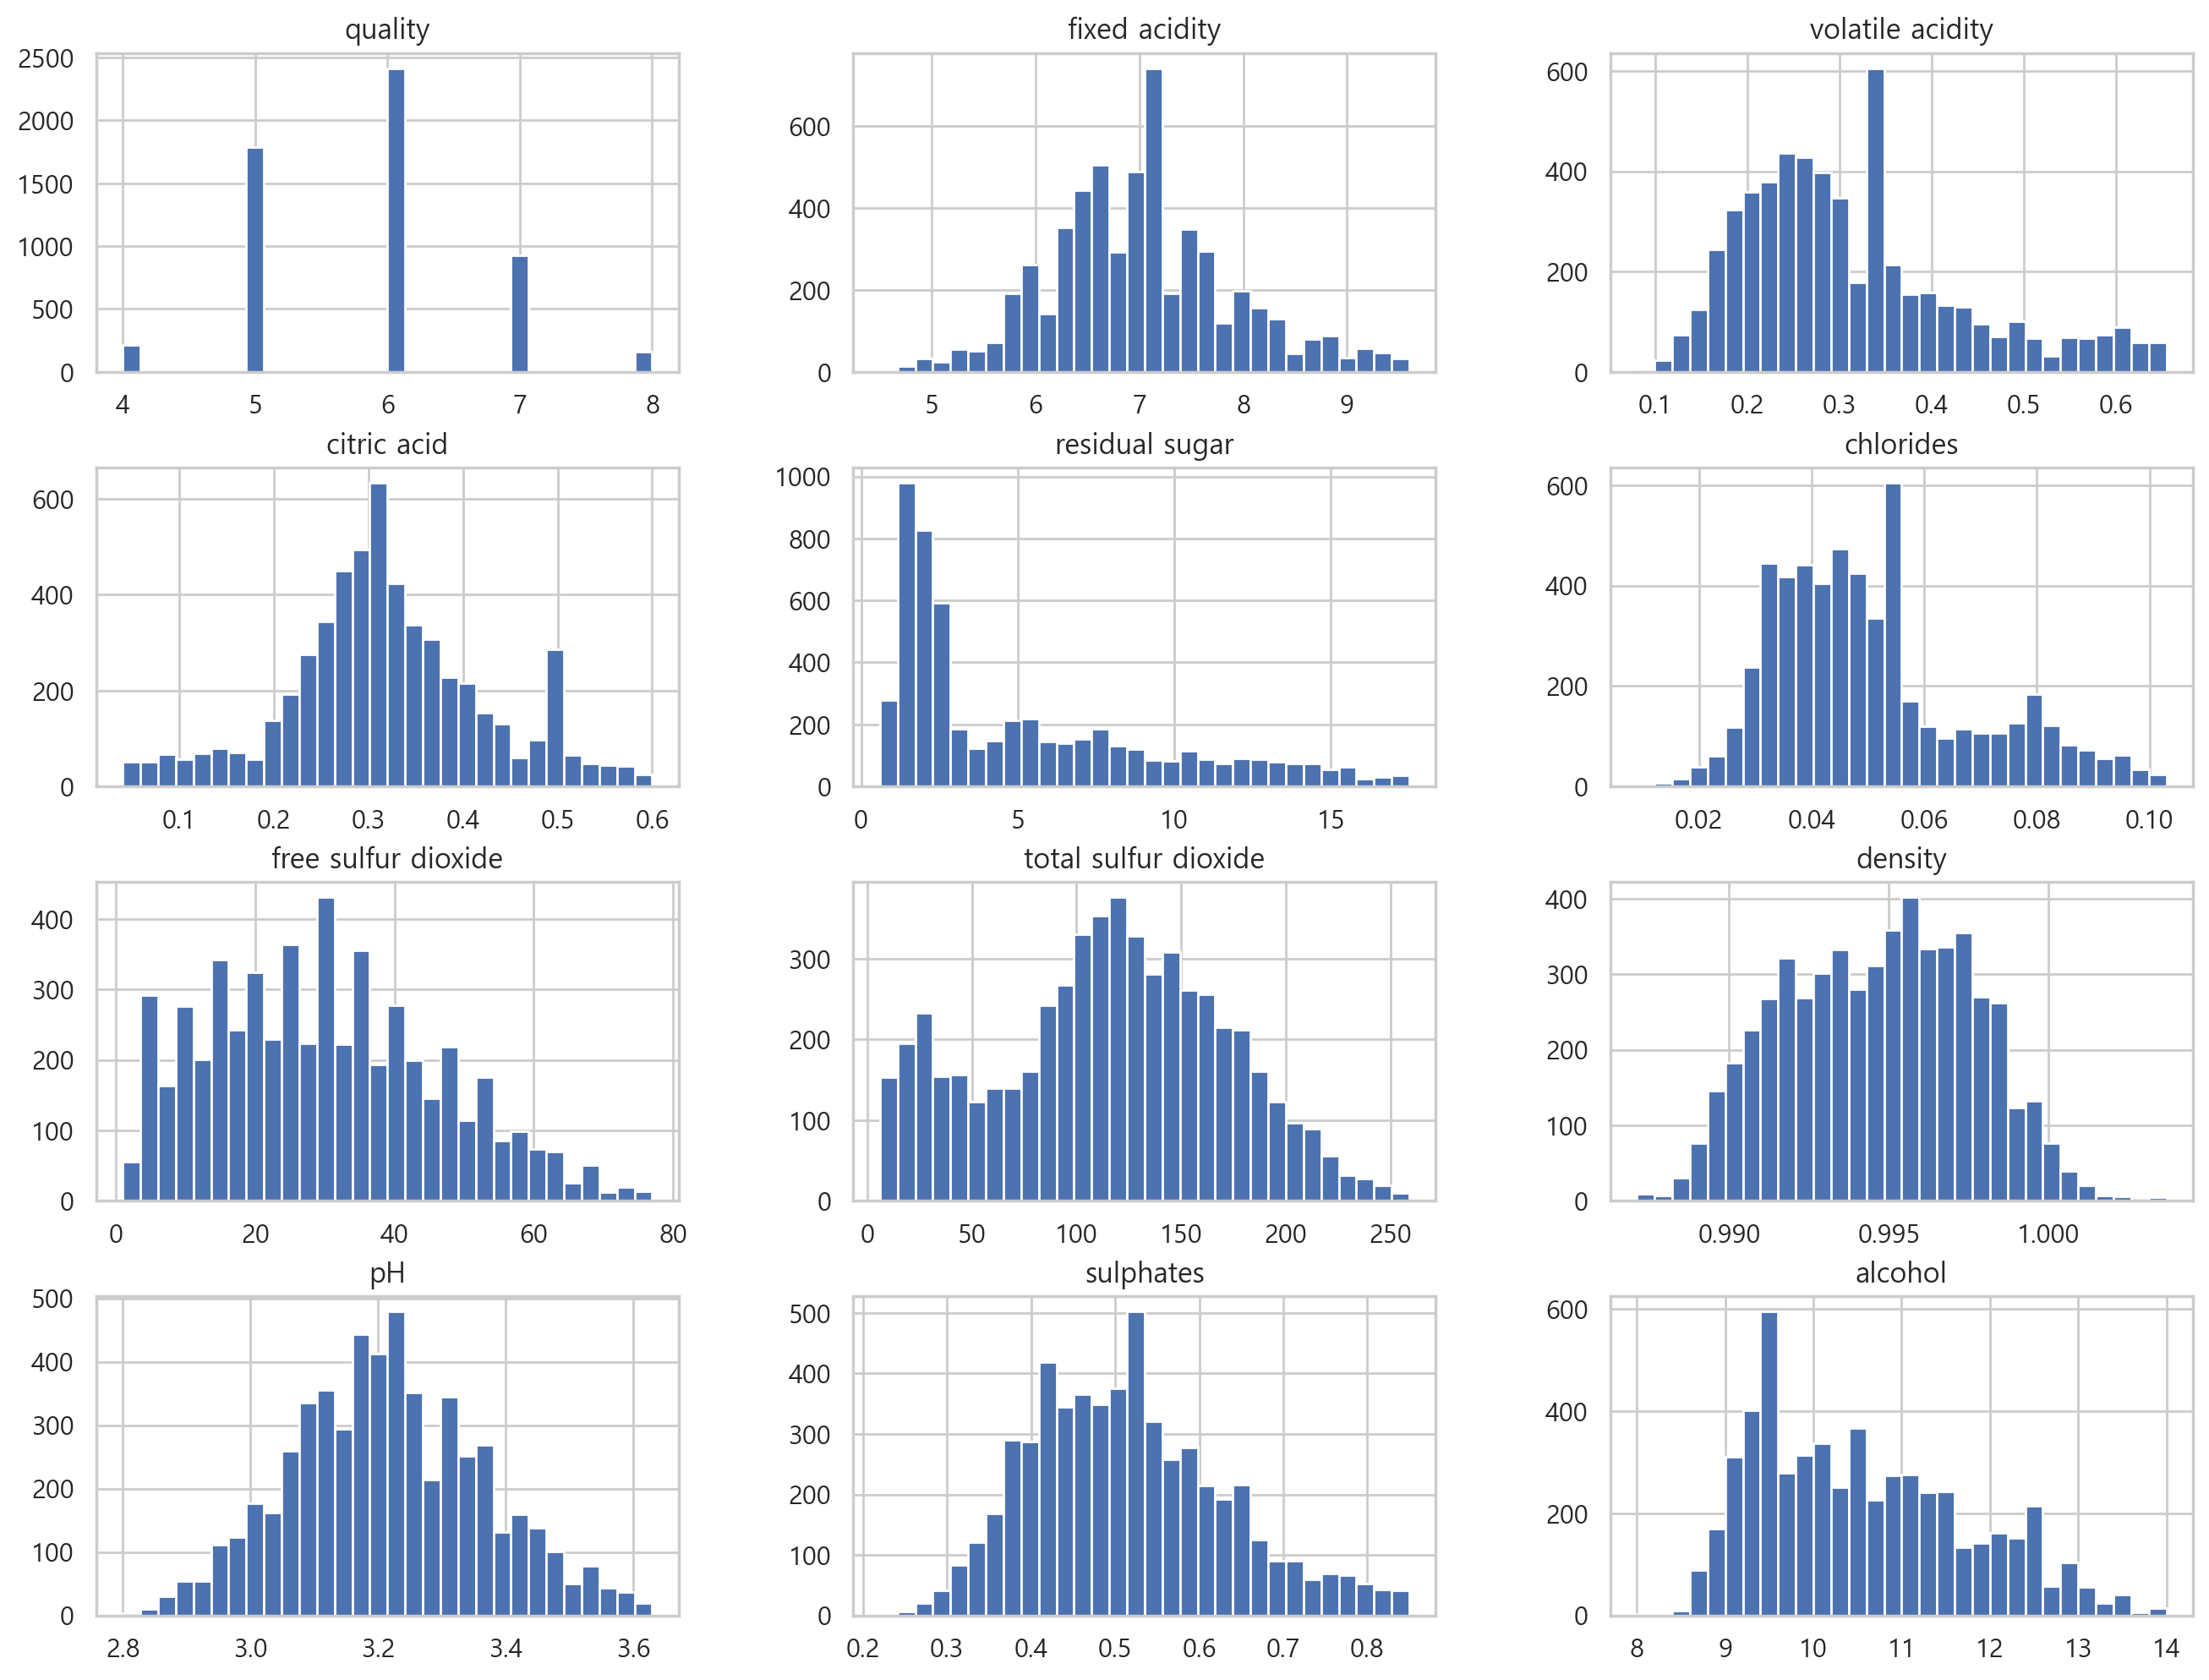

In [28]:
wine11_num = wine11.drop(columns="type")

wine11_num.hist(bins=30, figsize=(16,12))
plt.show()

In [29]:
# 변환 파이프라인


# 범주형 피쳐 리스트
cat_at = ["type"]

# 로그 변환할 피쳐 리스트
log_at=["fixed acidity", "volatile acidity", "density", "sulphates", "pH"]

#박스콕스 변환 리스트
boxcox_at = ["citric acid", "alcohol", "chlorides", "free sulfur dioxide", "total sulfur dioxide","residual sugar"]


# 범주형 피쳐를 위한 파이프라인 - onehot encode
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("encode", OneHotEncoder(handle_unknown="ignore"))
])



# 박스콕스 변환 파이프라인
boxcox_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("boxcox", PowerTransformer(method="box-cox")),  # 로그 변환 (np.log1p은 log(1 + x)를 계산)
    ("standardize", StandardScaler())])




# 로그 변환 파이프라인
log_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("log_transform", FunctionTransformer(np.log1p, validate=True)),  # 로그 변환 (np.log1p은 log(1 + x)를 계산)
    ("standardize", MinMaxScaler())
])





# 전체 전처리 파이프라인 정의
preprocessing = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, cat_at),
        ("boxcox", boxcox_pipeline, boxcox_at),  # 범주형 피쳐 파이프라인 적용
        ("log", log_pipeline, log_at)
    ]
)

# 데이터 전처리
trainset = preprocessing.fit_transform(trainset)
feature_names=  ["type_red", "type_white", "citric acid", "alcohol", "chlorides", "free sulfur dioxide", "total sulfur dioxide","residual sugar", "fixed acidity", "volatile acidity", "density", "sulphates", "pH" ]



trainset = pd.DataFrame(data = trainset, columns = feature_names)
trainset = trainset.drop(columns="type_white")
# 변환된 데이터 확인
print(trainset)

      type_red  citric acid  alcohol  chlorides  free sulfur dioxide  \
0         0.00         0.02     1.41      -1.24                 0.75   
1         1.00        -2.38    -0.63       1.84                -1.21   
2         0.00         0.02     1.62      -0.81                -0.87   
3         0.00         0.50    -1.20       0.02                 0.85   
...        ...          ...      ...        ...                  ...   
3513      0.00         1.92     1.23      -0.73                 0.26   
3514      1.00        -0.17    -0.13       1.03                -0.50   
3515      0.00         0.02    -1.20      -0.17                 0.59   
3516      0.00         0.97    -0.32      -0.04                -0.79   

      total sulfur dioxide  residual sugar  fixed acidity  volatile acidity  \
0                     0.35            1.07           0.39              0.32   
1                    -1.42           -0.48           0.65              0.96   
2                    -0.79           -0.59

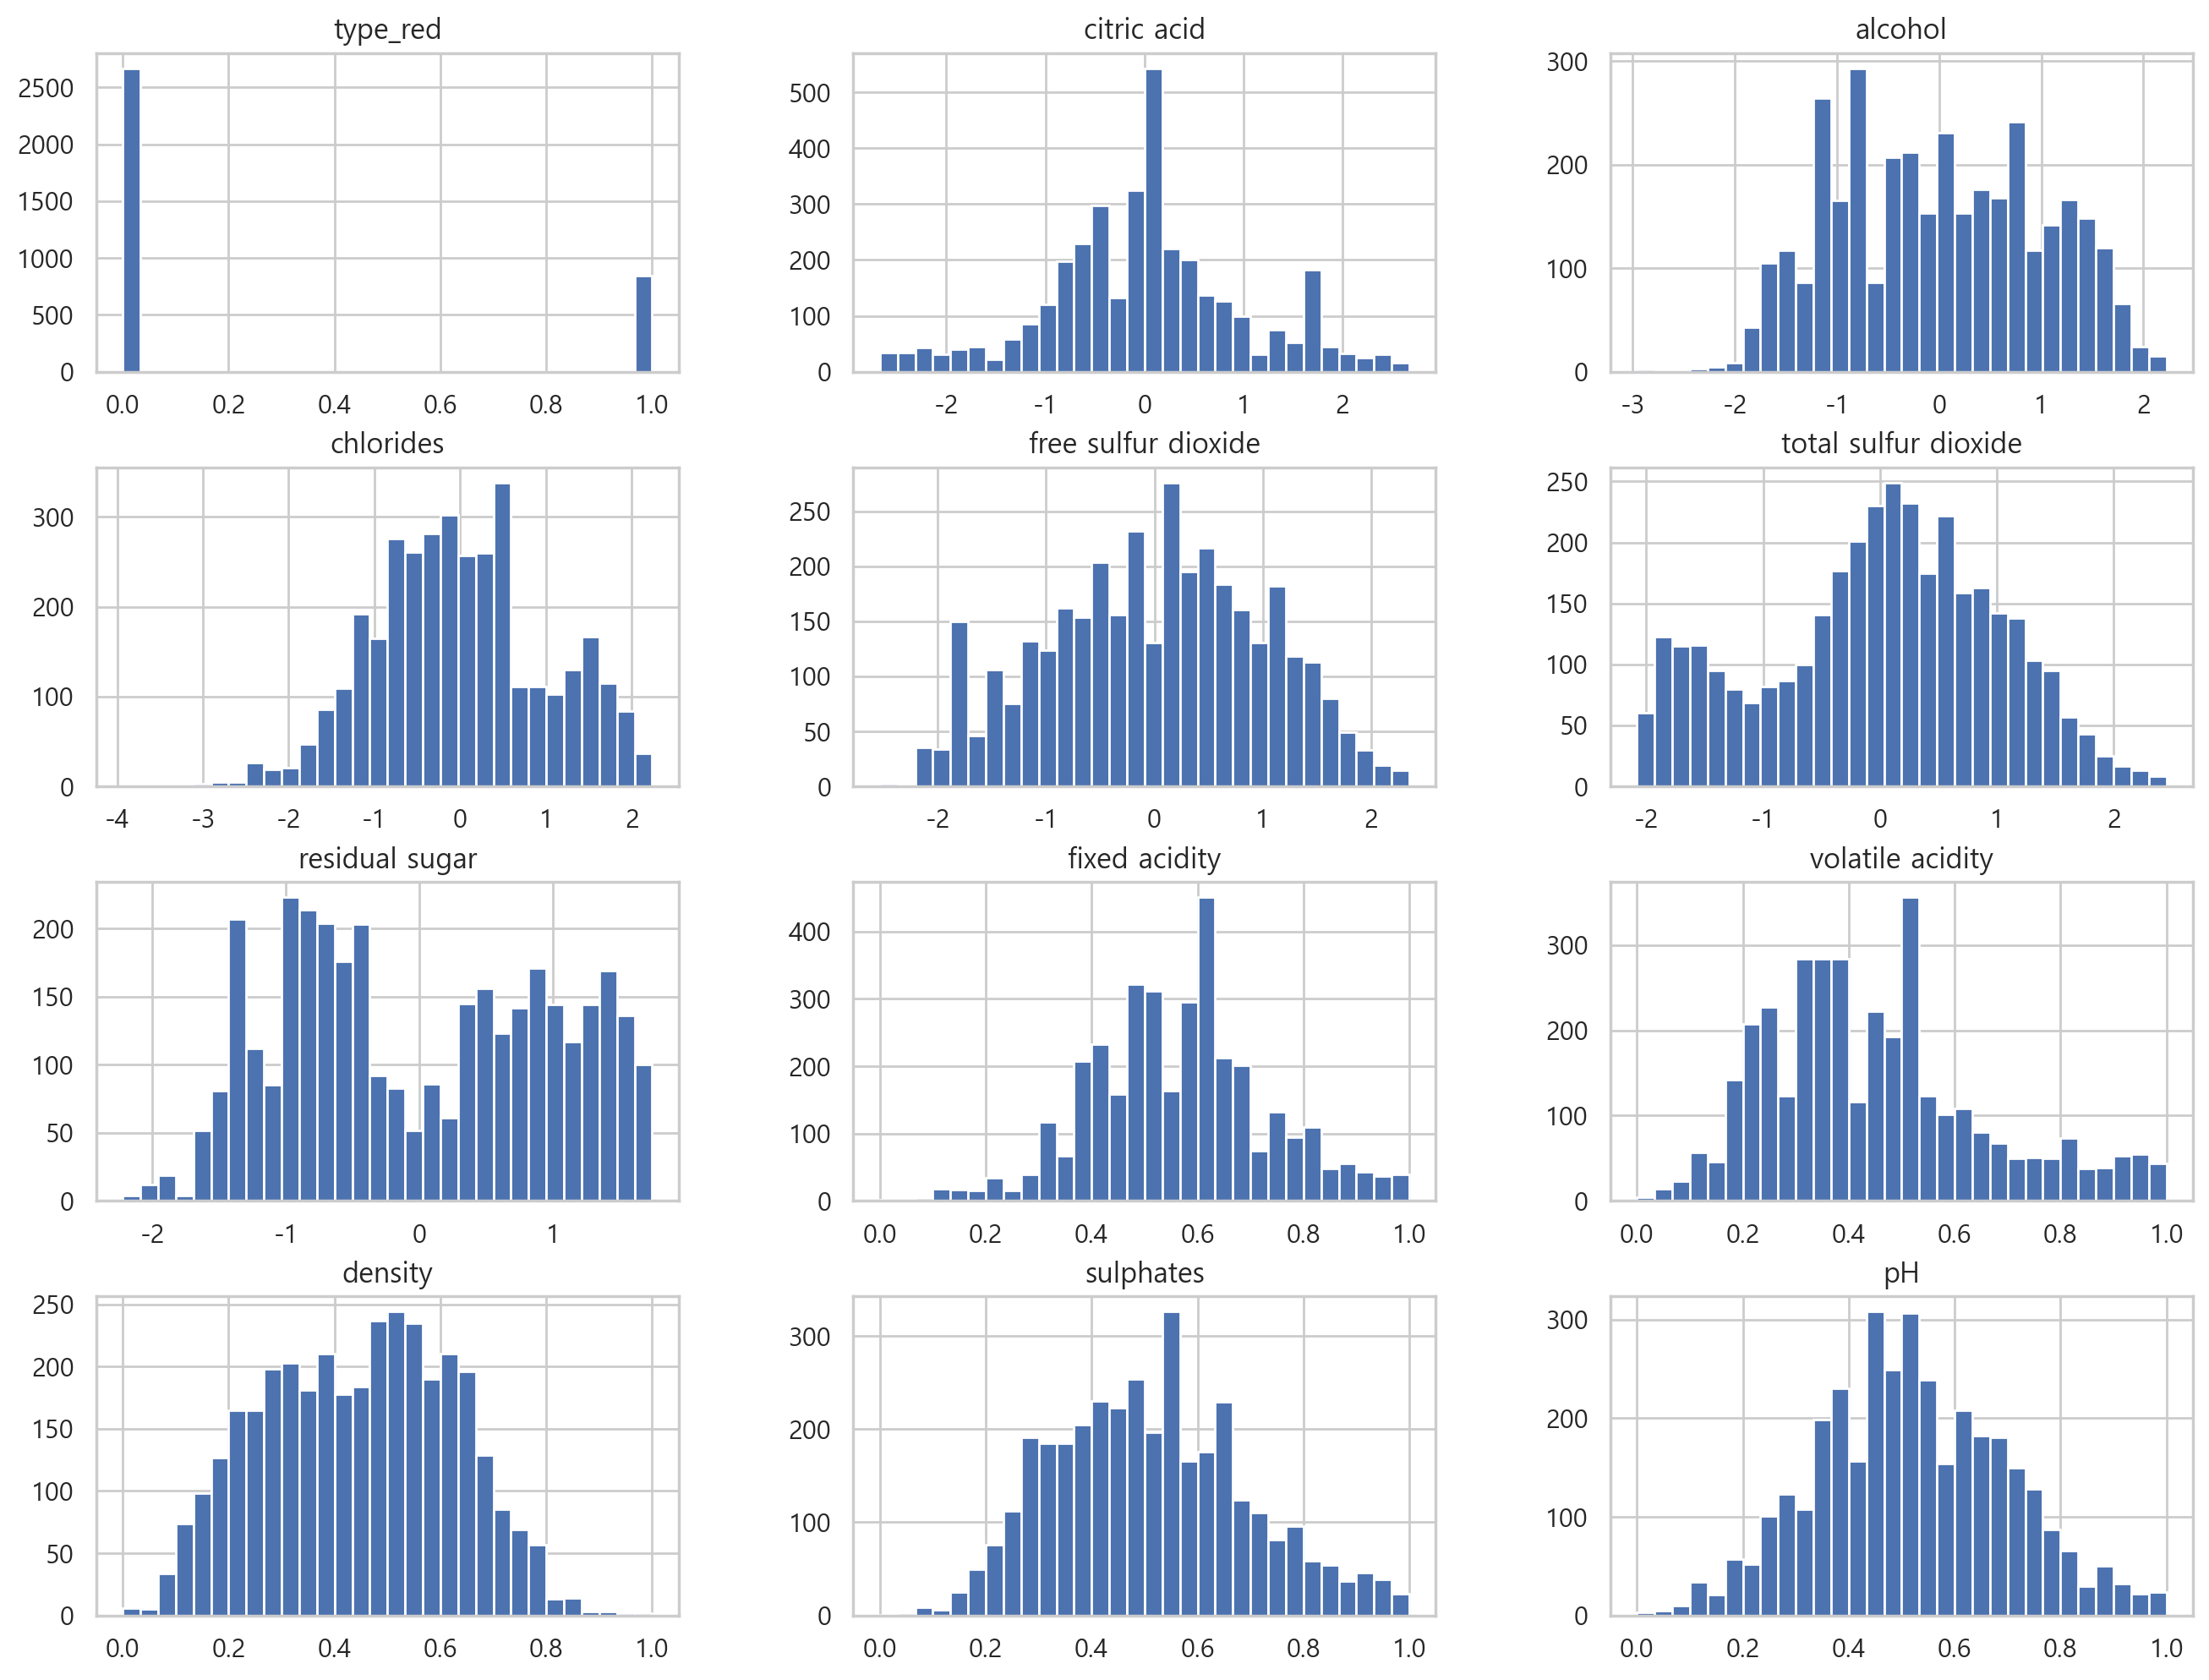

In [14]:
# 전처리 결과

# 마이너스 오류나서 붙인 코드
plt.rcParams['axes.unicode_minus'] = False


trainset.hist(bins=30, figsize=(16,12))
plt.show()

c:\Users\zezeg\.conda\envs\datavisual\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\zezeg\.conda\envs\datavisual\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\zezeg\.conda\envs\datavisual\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\zezeg\.conda\envs\datavisual\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

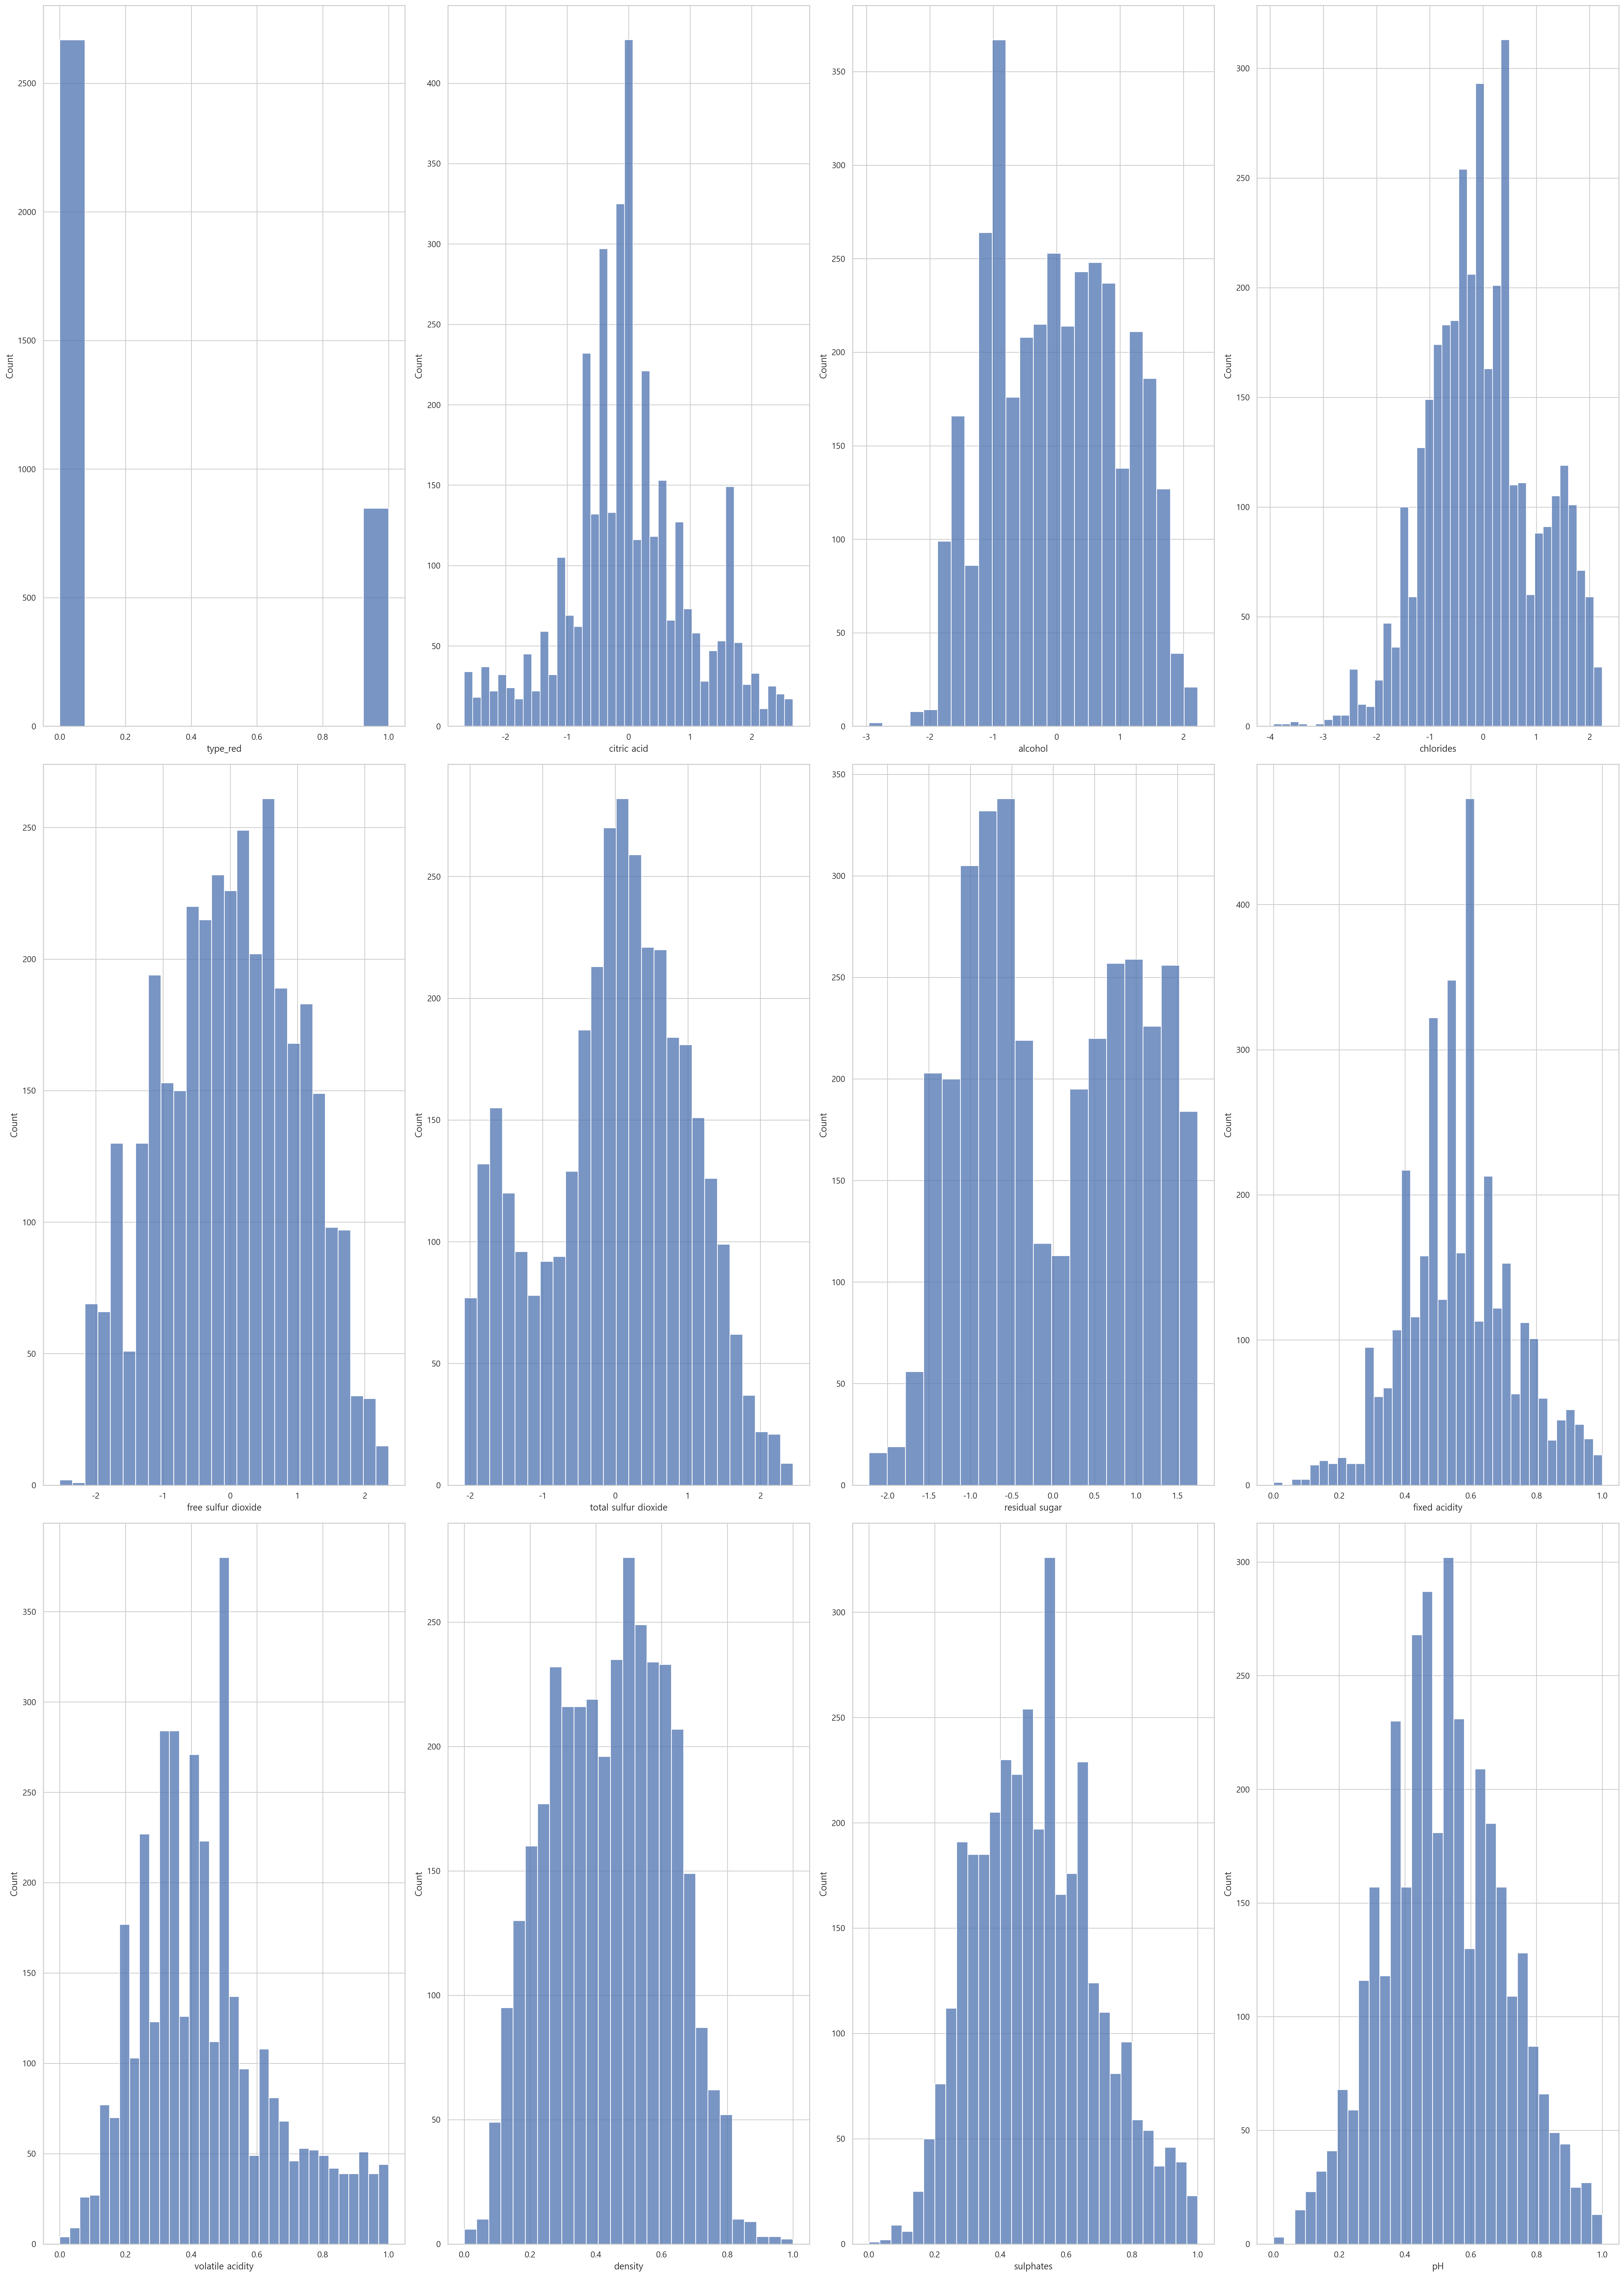

In [15]:
# histplot을 통해 그려보자


fig, ax1 = plt.subplots(3, 4, figsize=(30, 42))

column = trainset.columns

k=0
for i in range(3):
    for j in range(4):
        if k < len(column):
            sns.histplot(trainset[column[k]], ax=ax1[i][j])
            k=k+1
plt.tight_layout()
plt.show()


oversampling으로 trainset 다시 제작할 예정


undersampling은 정보에 손실을 줄 수 있기에 오버샘플링 기법을 사용할 것임. 특히 가장 많은 클래스와 가장 적은 클래스가

10배 이상 차이나기 때문에 특정 언더샘플링을 사용하면, 매우 많은 데이터가 손실될 우려가 있음



일반적으로, 전처리 후 오버샘플링을 하면 데이터의 일관성이 유지되기에 이렇게 한다고 함.

단, test set은 건드리지 않고, trainset에만 샘플링기법을 가해줘야 함에 유의.

# 모델링

## decison tree

In [16]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection as skm

sol 1 ) no oversampling

sol 2 ) oversampling

sol 3 ) 제한없는 트리 만들고, 가지치기

### 그리드 서치로 모수 탐색

In [18]:
# no oversampling

full_pipe = Pipeline([
    ("tree_clf", DecisionTreeClassifier(random_state=42))
])

# 파라미터 그리드 정의
param_grid = [{
    'tree_clf__max_depth': range(6,11),
    'tree_clf__max_features': range(3,13),
    'tree_clf__min_samples_split': [3,6],
    'tree_clf__min_samples_leaf': [3,6],
},{
    'tree_clf__max_depth': range(11,15),
    'tree_clf__max_features': range(3,13),
    'tree_clf__min_samples_split': [3,6],
    'tree_clf__min_samples_leaf': [3,6],
}]

# GridSearchCV 생성
grid_search = GridSearchCV(full_pipe, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

# GridSearchCV 수행
grid_search.fit(trainset, trainset_labels)

# 최적의 하이퍼파라미터와 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.2f}".format(grid_search.best_score_))

# 최적의 모델로 테스트 세트 예측
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
Best parameters found:  {'tree_clf__max_depth': 10, 'tree_clf__max_features': 5, 'tree_clf__min_samples_leaf': 3, 'tree_clf__min_samples_split': 3}
Best cross-validation F1 score: 0.52


In [20]:
# oversampling
# 원래는 max depth, max features만으로 분류하였으나, 결국 과적합을 피할 수 없어 다른 hyperparam.들도 조정하였음.

full_pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("tree_clf", DecisionTreeClassifier(random_state=42))
])

# 파라미터 그리드 정의
param_grid = [{
    'smote__k_neighbors': [2,3,5],
    'tree_clf__max_depth': range(6,11),
    'tree_clf__max_features': range(2,13),
    'tree_clf__min_samples_split': [3,6],
    'tree_clf__min_samples_leaf': [3,6]
},
{
    'smote__k_neighbors': [2,3,5],
    'tree_clf__max_depth': range(11,15),
    'tree_clf__max_features': range(2,13),
    'tree_clf__min_samples_split': [3,6],
    'tree_clf__min_samples_leaf': [3,6]
}]

# GridSearchCV 생성
grid_search = GridSearchCV(full_pipe, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

# GridSearchCV 수행
grid_search.fit(trainset, trainset_labels)

# 최적의 하이퍼파라미터와 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.2f}".format(grid_search.best_score_))

# 최적의 모델로 테스트 세트 예측
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 1188 candidates, totalling 3564 fits
Best parameters found:  {'smote__k_neighbors': 5, 'tree_clf__max_depth': 14, 'tree_clf__max_features': 8, 'tree_clf__min_samples_leaf': 3, 'tree_clf__min_samples_split': 3}
Best cross-validation F1 score: 0.49


In [21]:
# 가지치기


full_pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("tree_clf3", DecisionTreeClassifier(random_state=42))
])


tree_clf3 = DecisionTreeClassifier(random_state=42)
ccp_path = tree_clf3.cost_complexity_pruning_path(trainset, trainset_labels)



# 파라미터 그리드 정의
param_grid = {
    'smote__k_neighbors': [2,3,5],
    'tree_clf3__ccp_alpha': ccp_path.ccp_alphas,
    'tree_clf3__max_features': range(3,13)
}
    



grid_search = GridSearchCV(full_pipe, param_grid, refit = True, cv=3, scoring='f1_weighted',verbose=1, n_jobs=-1)

# GridSearchCV 수행
grid_search.fit(trainset, trainset_labels)

# 최적의 하이퍼파라미터와 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.2f}".format(grid_search.best_score_))

# 최적의 모델로 테스트 세트 예측
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 18120 candidates, totalling 54360 fits
Best parameters found:  {'smote__k_neighbors': 5, 'tree_clf3__ccp_alpha': 0.0, 'tree_clf3__max_features': 11}
Best cross-validation F1 score: 0.52


### 모델 학습

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [34]:
# no oversampling
tree_clf = DecisionTreeClassifier(random_state=42, max_depth = 10, max_features= 5, min_samples_leaf= 3, min_samples_split = 3)



# oversampling
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_over, y_train_over =  smote.fit_resample(trainset, trainset_labels)
tree_clf2 = DecisionTreeClassifier(random_state=42, max_depth = 14, max_features= 8, min_samples_leaf= 3, min_samples_split = 3)




tree_clf.fit(trainset, trainset_labels)
tree_clf2.fit(X_train_over, y_train_over)



DecisionTreeClassifier(max_depth=14, max_features=8, min_samples_leaf=3,
                       min_samples_split=3, random_state=42)

In [35]:

accuracy = tree_clf.score(trainset, trainset_labels)
print(f"Accuracy: {accuracy:.2f}")

# 참고 : accuracy 0.83을 통해 고른 모수가 과적합되었을 수 있다고 인식.

Accuracy: 0.73


In [36]:
accuracy = tree_clf2.score(X_train_over, y_train_over)
print(f"Accuracy: {accuracy:.2f}")

# 동일

Accuracy: 0.87


In [37]:
# 참고 : smote 오버샘플링 - 모든 클래스를 가장 많은 클래스 개수로 증강.

y_train_over.value_counts()

quality
7    1545
6    1545
8    1545
5    1545
4    1545
Name: count, dtype: int64

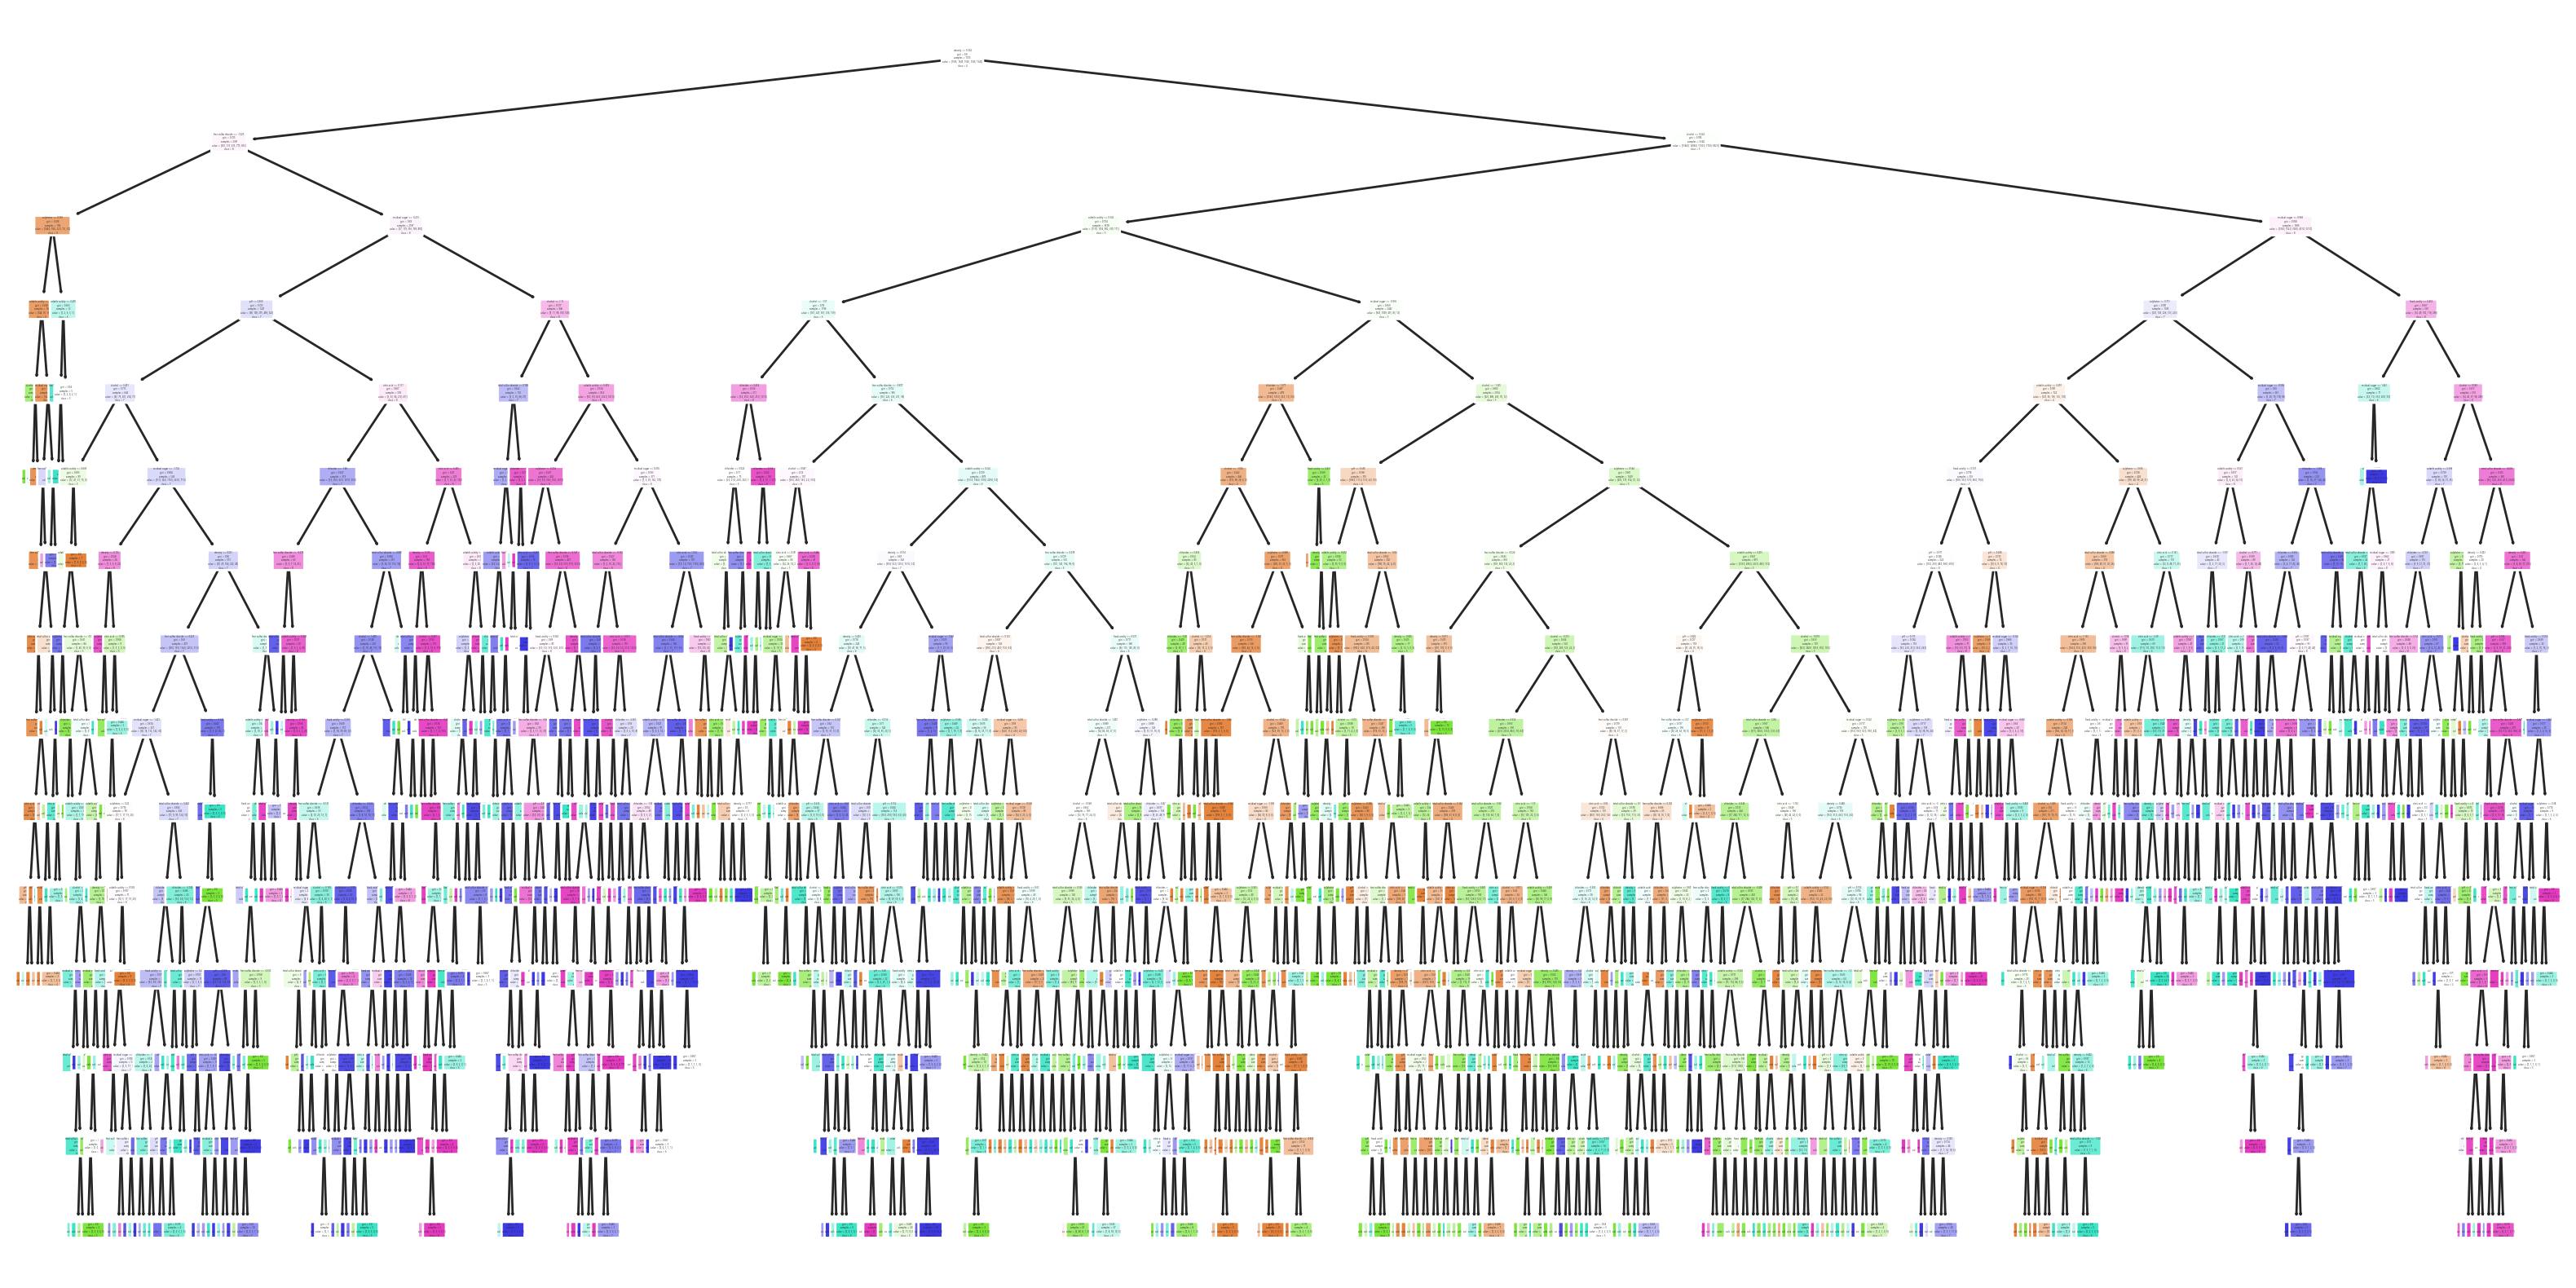

In [38]:
# tree 구조 확인


# oversampling
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize = (20,10))

plot_tree(
        tree_clf2,
        feature_names= ["type_red", "citric acid", "alcohol", "chlorides", "free sulfur dioxide", "total sulfur dioxide","residual sugar", "fixed acidity", "volatile acidity", "density", "sulphates", "pH" ],
        class_names =["4","5","6","7","8"],
        rounded=True,
        filled=True
    )

plt.show()

In [39]:
# validset 전처리

validset1 = preprocessing.transform(validset)

names = ["type_red", "type_white","citric acid", "alcohol", "chlorides", "free sulfur dioxide", "total sulfur dioxide","residual sugar", "fixed acidity", "volatile acidity", "density", "sulphates", "pH" ]

validset1 = pd.DataFrame(validset1, columns=names)

validset1 = validset1.drop(columns="type_white")

validset1

type_red  citric acid  alcohol  chlorides  free sulfur dioxide  \
0        0.00         0.01     2.10      -0.44                -0.64   
1        0.00         0.01    -2.00      -0.44                 1.56   
2        1.00         0.01     0.84       2.15                 1.20   
3        0.00        -0.26    -0.22      -0.37                 1.47   
..        ...          ...      ...        ...                  ...   
876      0.00         0.12     0.62      -0.73                -0.16   
877      0.00        -0.26     0.91      -1.43                 0.85   
878      0.00         0.31     1.57       2.03                -0.36   
879      0.00         1.82    -1.20      -0.04                 1.69   

     total sulfur dioxide  residual sugar  fixed acidity  volatile acidity  \
0                    0.11           -0.11           0.41              0.50   
1                    0.80            1.20           0.63              0.45   
2                   -0.92           -0.59           0.49              0.89   
3                    0.75            1.13           0.53              0.32   
..                    ...             ...            ...               ...   
876                 -0.34            0.86           0.28              0.47   
877                 -0.14            0.50           0.49              0.27   
878                 -0.61           -0.86           0.88              0.59   
879                  1.29            0.95           0.49              0.34   

     density  sulphates   pH  
0       0.18       0.54 0.51  
1       0.63       0.41 0.34  
2       0.49       0.77 0.96  
3       0.52       0.51 0.40  
..       ...        ...  ...  
876     0.32       0.48 0.57  
877     0.23       0.38 0.17  
878     0.17       0.56 0.20  
879     0.53       0.48 0.53  

[880 rows x 12 columns]

In [43]:
b = tree_clf.feature_importances_

feature_names = ["type_red", "citric acid", "alcohol", "chlorides", "free sulfur dioxide", "total sulfur dioxide","residual sugar", "fixed acidity", "volatile acidity", "density", "sulphates", "pH" ]

importance1 = pd.DataFrame({
    'Feature': feature_names,
    'Importance': b
})
importance1 =importance1.sort_values(by="Importance",ascending=False).reset_index(drop=True)




a = tree_clf2.feature_importances_

feature_names = ["type_red", "citric acid", "alcohol", "chlorides", "free sulfur dioxide", "total sulfur dioxide","residual sugar", "fixed acidity", "volatile acidity", "density", "sulphates", "pH" ]

importance2 = pd.DataFrame({
    'Feature': feature_names,
    'Importance': a
})
importance2=importance2.sort_values(by="Importance",ascending=False).reset_index(drop=True)



print("\n non oversampling tree model")
display(importance1)

print("\n oversampling tree model")
display(importance2)


 non oversampling tree model


Feature  Importance
0            alcohol        0.21
1          chlorides        0.12
2   volatile acidity        0.10
3          sulphates        0.10
..               ...         ...
8            density        0.07
9        citric acid        0.04
10     fixed acidity        0.04
11          type_red        0.00

[12 rows x 2 columns]


 oversampling tree model


Feature  Importance
0               alcohol        0.14
1   free sulfur dioxide        0.11
2               density        0.11
3      volatile acidity        0.10
..                  ...         ...
8             sulphates        0.07
9                    pH        0.06
10        fixed acidity        0.05
11             type_red        0.00

[12 rows x 2 columns]

### 평가(1)

In [44]:
# valid set에 대한 예측
valid_pred1 = tree_clf.predict(validset1)
valid_pred2 = tree_clf2.predict(validset1)

accuracy = accuracy_score(validset_labels, valid_pred1)
f1 = f1_score(validset_labels, valid_pred1, average='weighted')
precision = precision_score(validset_labels, valid_pred1, average='weighted')
recall = recall_score(validset_labels, valid_pred1, average='weighted')

accuracy2 = accuracy_score(validset_labels, valid_pred2)
f12 = f1_score(validset_labels, valid_pred2, average='weighted')
precision2 = precision_score(validset_labels, valid_pred2, average='weighted')
recall2 = recall_score(validset_labels, valid_pred2, average='weighted')

# 결과를 딕셔너리로 저장
results_dict = {
    'no oversampling tree': {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    },
    'oversampling tree': {
        'accuracy': accuracy2,
        'f1': f12,
        'precision': precision2,
        'recall': recall2
    }
}

# 데이터프레임으로 변환
results = pd.DataFrame(results_dict)

# 결과 출력
print(results)


           no oversampling tree  oversampling tree
accuracy                   0.56               0.51
f1                         0.55               0.53
precision                  0.55               0.56
recall                     0.56               0.51


오버샘플링 한 모델의 score가 좀 낮다. 왜 성능이 떨어졌는지 혼동행렬로 살펴봐야겠다

혼동행렬 시각화

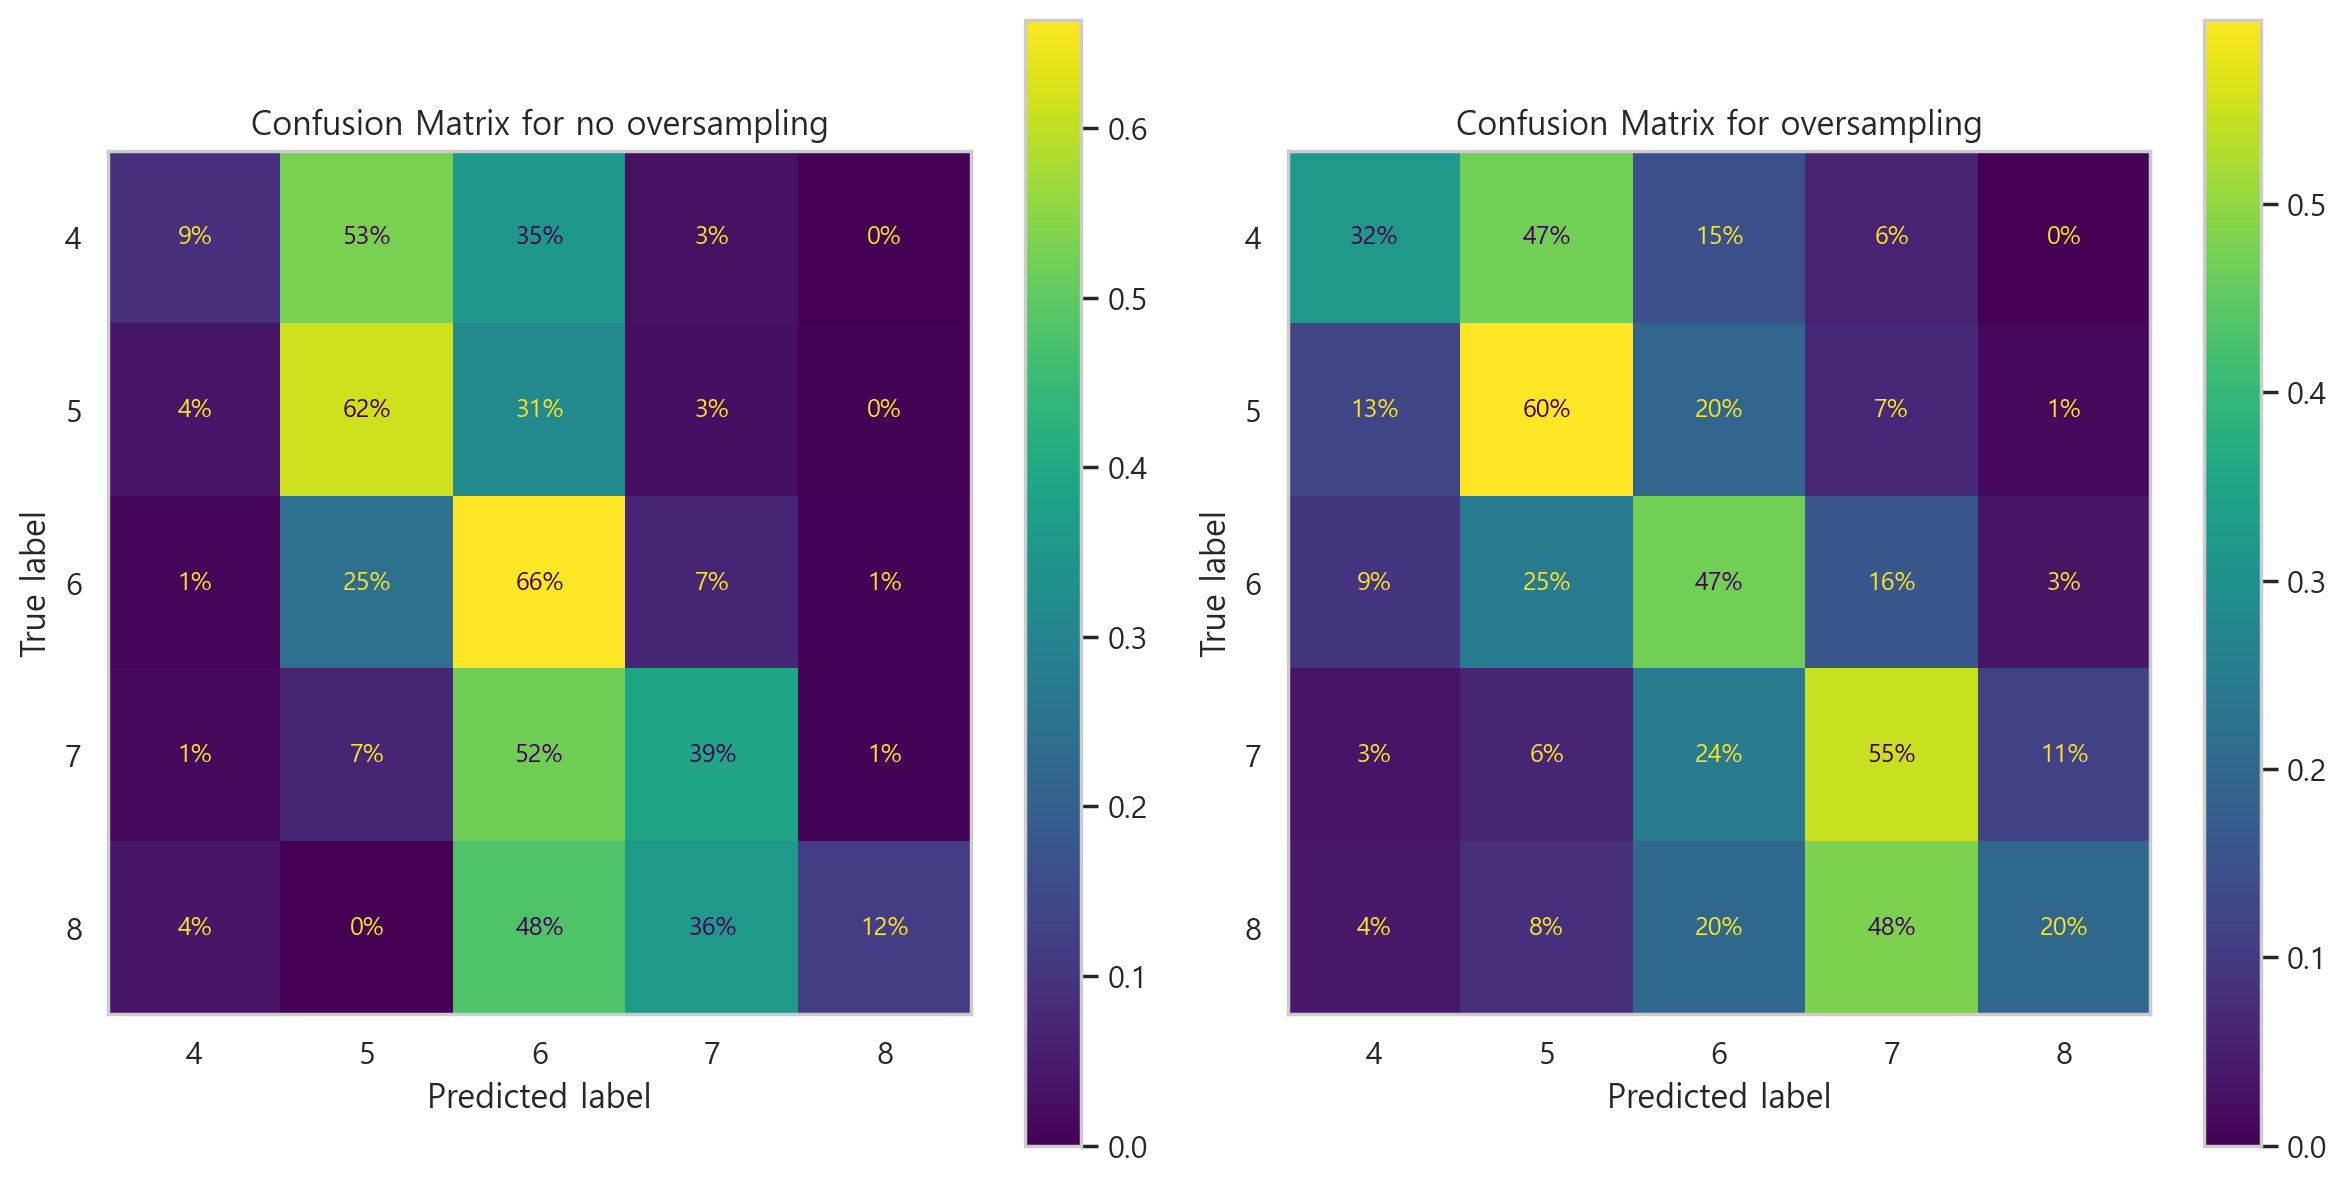

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 예측 결과
y_pred1 = valid_pred1
y_pred2 = valid_pred2

# 폰트 크기 설정
plt.rc('font', size=9)

# Subplots 설정
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# 첫 번째 혼동 행렬 시각화
ConfusionMatrixDisplay.from_predictions(validset_labels, y_pred1, ax=ax[0], normalize='true', values_format='.0%')
ax[0].set_title('Confusion Matrix for no oversampling')
ax[0].grid(False)

# 두 번째 혼동 행렬 시각화
ConfusionMatrixDisplay.from_predictions(validset_labels, y_pred2, ax=ax[1], normalize='true', values_format='.0%')
ax[1].set_title('Confusion Matrix for oversampling')
ax[1].grid(False)

# 그래프 표시
plt.tight_layout()
plt.show()

종합 score는 no oversampling이 높지만, 적은 class에 대한 예측에 있어 oversampling이 우위에 있음.

oversampling + 가지치기기법 결과 확인

In [46]:
best_model

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('tree_clf3',
                 DecisionTreeClassifier(max_features=11, random_state=42))])

[Text(0.3706086789885853, 0.9814814814814815, 'density <= 0.304\ngini = 0.8\nsamples = 7725\nvalue = [1545, 1545, 1545, 1545, 1545]'),
 Text(0.08844575877322589, 0.9444444444444444, 'free sulfur dioxide <= -1.225\ngini = 0.725\nsamples = 2381\nvalue = [201, 137, 415, 775, 853]'),
 Text(0.009146745614422695, 0.9074074074074074, 'volatile acidity <= 0.276\ngini = 0.426\nsamples = 194\nvalue = [144.0, 18.0, 22.0, 7.0, 3.0]'),
 Text(0.004241968980601829, 0.8703703703703703, 'sulphates <= 0.225\ngini = 0.568\nsamples = 13\nvalue = [0, 6, 6, 1, 0]'),
 Text(0.0035349741505015246, 0.8333333333333334, 'gini = 0.0\nsamples = 4\nvalue = [0, 4, 0, 0, 0]'),
 Text(0.0049489638107021346, 0.8333333333333334, 'pH <= 0.524\ngini = 0.494\nsamples = 9\nvalue = [0, 2, 6, 1, 0]'),
 Text(0.004241968980601829, 0.7962962962962963, 'gini = 0.0\nsamples = 6\nvalue = [0, 0, 6, 0, 0]'),
 Text(0.005655958640802439, 0.7962962962962963, 'sulphates <= 0.616\ngini = 0.444\nsamples = 3\nvalue = [0, 2, 0, 1, 0]'),
 Text(

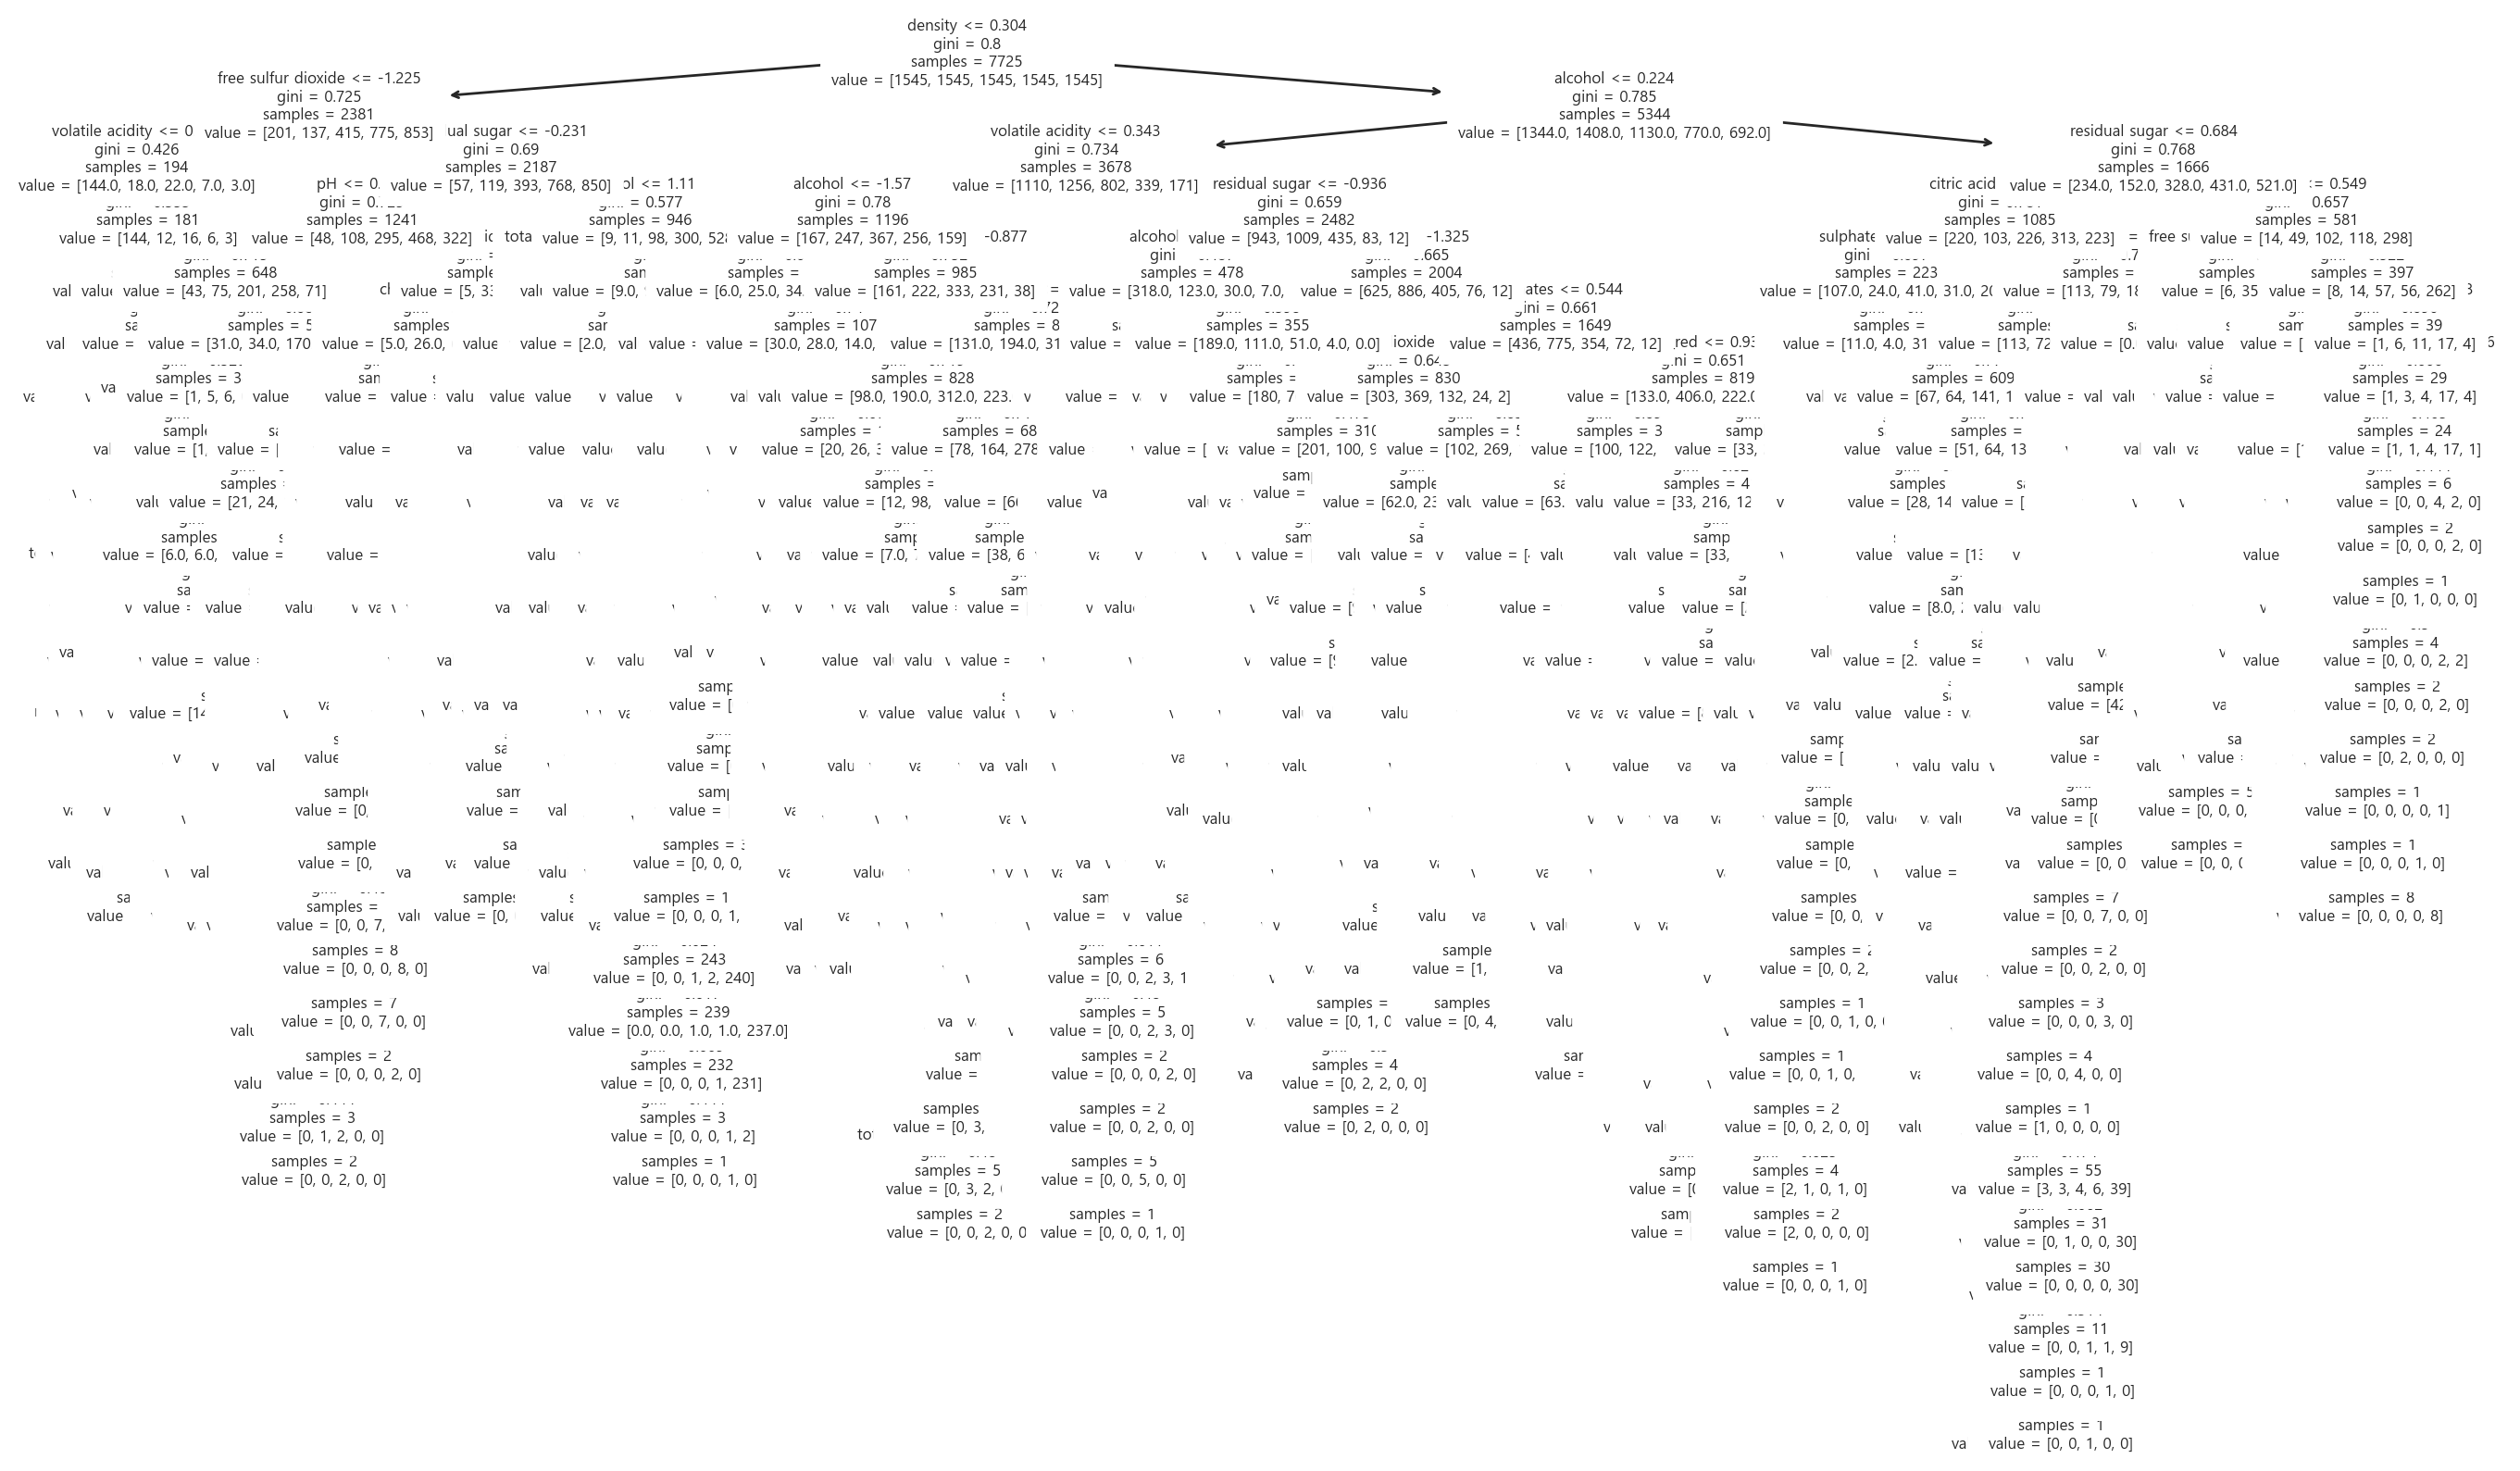

In [47]:
fig, ax = plt.subplots(figsize=(16, 10))

best_ = grid_search.best_estimator_.named_steps['tree_clf3']
plot_tree(best_, feature_names=trainset.columns.tolist(), fontsize=6, ax=ax)

In [51]:
# accuracy tree 3 in valid set

round(accuracy_score(validset_labels, best_.predict(validset1)),2)

0.55

In [53]:
# model 3 score in valid set

accuracy = accuracy_score(validset_labels, best_.predict(validset1))
f1 = f1_score(validset_labels, best_.predict(validset1), average='weighted')
precision = precision_score(validset_labels, best_.predict(validset1), average='weighted')
recall = recall_score(validset_labels, best_.predict(validset1), average='weighted')

# 결과를 딕셔너리로 저장
results_dict = {
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'Precision': [precision],
    'Recall': [recall]
}

# 데이터프레임으로 변환
results = pd.DataFrame(results_dict)

# 결과 출력
print(results)

   Accuracy  F1 Score  Precision  Recall
0      0.55      0.56       0.58    0.55


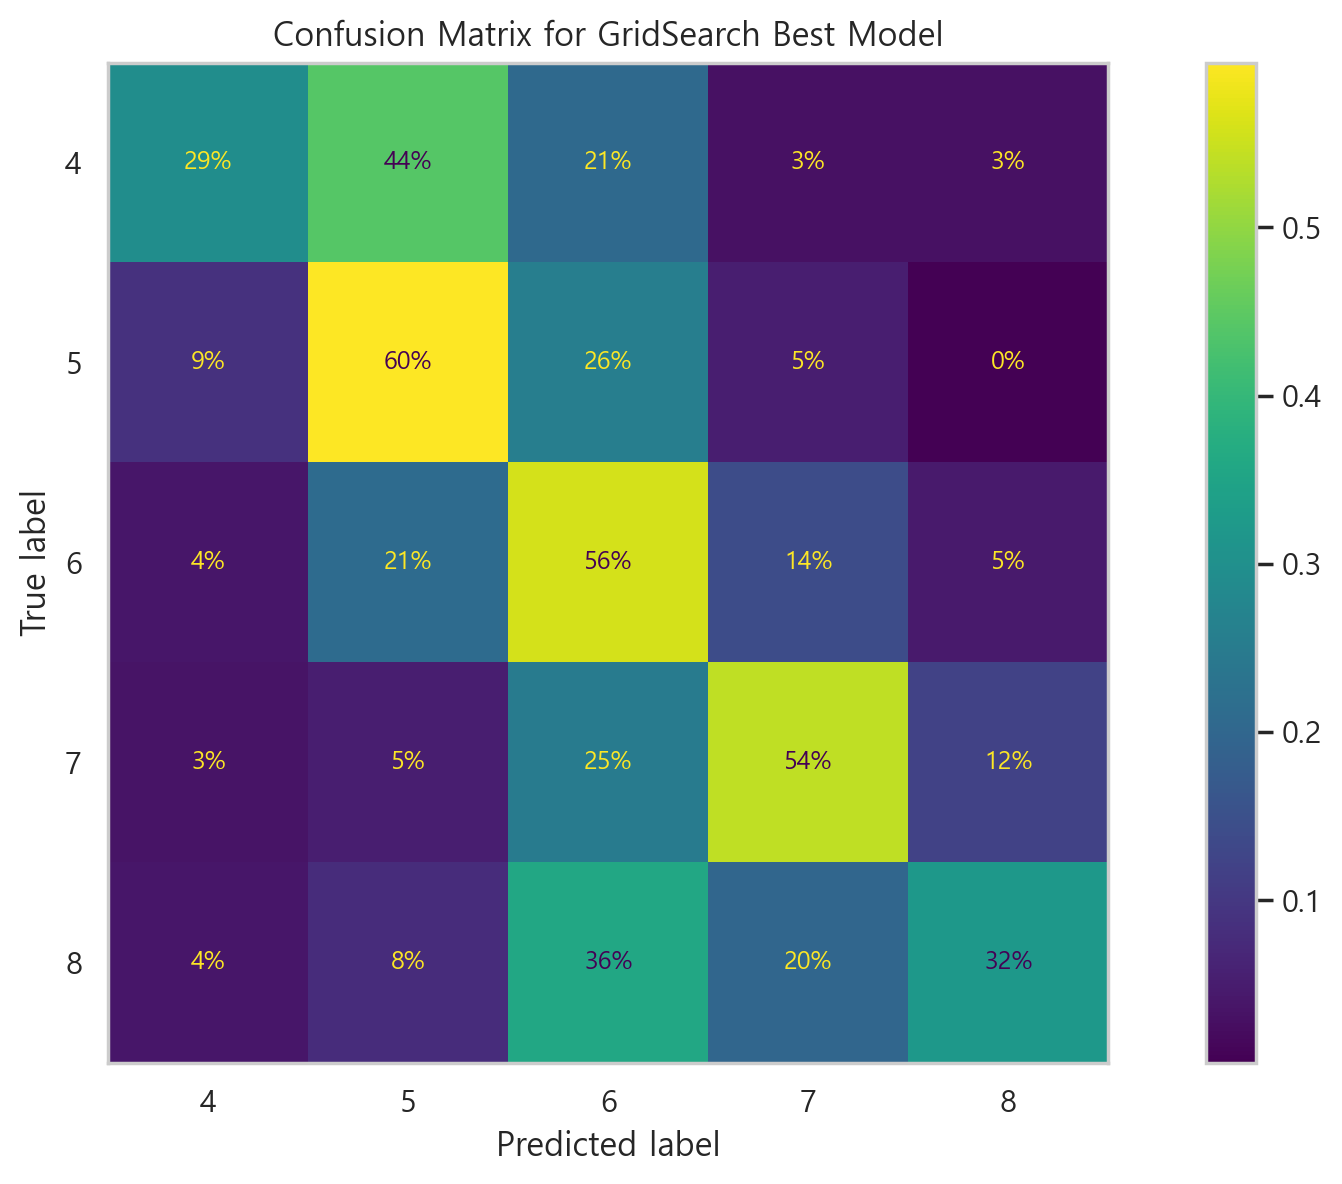

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# 예측 결과
y_pred_best = best_.predict(validset1)


# Confusion matrix 시각화
fig, ax = plt.subplots(figsize=(10, 6))
disp = ConfusionMatrixDisplay.from_predictions(validset_labels, y_pred_best, ax=ax, normalize='true', values_format='.0%')

# 격자 지우기
ax.grid(False)

# 제목 추가
ax.set_title('Confusion Matrix for GridSearch Best Model')

# 그래프 표시
plt.tight_layout()
plt.show()


In [61]:
# valid set에 대한 예측
valid_pred1 = tree_clf.predict(validset1)
valid_pred2 = tree_clf.predict(validset1)
valid_pred3 = best_.predict(validset1)

# 각 모델에 대한 성능 계산
accuracy = accuracy_score(validset_labels, valid_pred1)
f1 = f1_score(validset_labels, valid_pred1, average='weighted')
precision = precision_score(validset_labels, valid_pred1, average='weighted')
recall = recall_score(validset_labels, valid_pred1, average='weighted')

accuracy2 = accuracy_score(validset_labels, valid_pred2)
f12 = f1_score(validset_labels, valid_pred2, average='weighted')
precision2 = precision_score(validset_labels, valid_pred2, average='weighted')
recall2 = recall_score(validset_labels, valid_pred2, average='weighted')

accuracy3 = accuracy_score(validset_labels, valid_pred3)
f13 = f1_score(validset_labels, valid_pred3, average='weighted')
precision3 = precision_score(validset_labels, valid_pred3, average='weighted')
recall3 = recall_score(validset_labels, valid_pred3, average='weighted')

# 결과를 딕셔너리로 저장
results_dict = {
    'no oversampling tree': {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    },
    'oversampling tree': {
        'accuracy': accuracy2,
        'f1': f12,
        'precision': precision2,
        'recall': recall2
    },
    'branching tree': {
        'accuracy': accuracy3,
        'f1': f13,
        'precision': precision3,
        'recall': recall3
    }
}

# 데이터프레임으로 변환
results = pd.DataFrame(results_dict)

# 결과 출력
print(results)


           no oversampling tree  oversampling tree  branching tree
accuracy                   0.56               0.56            0.55
f1                         0.55               0.55            0.56
precision                  0.55               0.55            0.58
recall                     0.56               0.56            0.55


가지치기한 모델이, 증강한 데이터를 이용하여 소수 클래스도 잘 잡아 내었다.

오버샘플링을 사용한 모델들이 소수 클래스 데이터를 잡는 데 성공하긴 했으나, 다른 클래스에 비해 정확도가 높지는 않음


또한 다수 데이터를 왜 못잡았는지 살펴볼 여지가 있다.

## randomforest

In [62]:
from sklearn.ensemble import RandomForestClassifier

### 그리드 서치를 통한 탐색

In [64]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# RandomForest + SMOTE Pipeline 설정
full_pipe = Pipeline([
    ("smote", SMOTE(random_state=42)),
    ("forest_clf", RandomForestClassifier(random_state=42))
])

# 파라미터 그리드 정의
param_grid = [
    {
        'smote__k_neighbors': [2, 3, 5],
        'forest_clf__max_depth': range(5, 11),
        'forest_clf__max_features': range(4, 13),
        'forest_clf__min_samples_split': [2, 4]
    },
    {
        'smote__k_neighbors': [2, 3, 5],
        'forest_clf__max_depth': range(11, 15),
        'forest_clf__max_features': range(4, 13),
        'forest_clf__min_samples_split': [2, 4]
    }
]

# GridSearchCV 생성
grid_search = GridSearchCV(full_pipe, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

# GridSearchCV 수행
grid_search.fit(trainset, trainset_labels)

# 최적의 하이퍼파라미터와 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.2f}".format(grid_search.best_score_))

# 최적의 모델로 테스트 세트 예측
best_model = grid_search.best_estimator_



Fitting 3 folds for each of 540 candidates, totalling 1620 fits
Best parameters found:  {'forest_clf__max_depth': 14, 'forest_clf__max_features': 4, 'forest_clf__min_samples_split': 2, 'smote__k_neighbors': 2}
Best cross-validation F1 score: 0.58


In [65]:
# in valid set

smote = SMOTE(random_state=42, k_neighbors=2)
X_train_over, y_train_over =  smote.fit_resample(trainset, trainset_labels)


forest_clf = RandomForestClassifier(random_state= 42, max_depth=14, max_features=4, min_samples_split=3)

forest_clf.fit(X_train_over, y_train_over)


RandomForestClassifier(max_depth=14, max_features=4, min_samples_split=3,
                       random_state=42)

In [66]:
a = forest_clf.feature_importances_

feature_names = ["type_red", "citric acid", "alcohol", "chlorides", "free sulfur dioxide", "total sulfur dioxide","residual sugar", "fixed acidity", "volatile acidity", "density", "sulphates", "pH" ]

importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': a
})
importance.sort_values(by="Importance",ascending=False).reset_index(drop=True)

Feature  Importance
0               alcohol        0.15
1   free sulfur dioxide        0.11
2        residual sugar        0.09
3      volatile acidity        0.09
..                  ...         ...
8           citric acid        0.07
9                    pH        0.07
10        fixed acidity        0.07
11             type_red        0.01

[12 rows x 2 columns]

In [67]:
# valid set에 대한 예측
valid_pred1 = forest_clf.predict(validset1)

accuracy = accuracy_score(validset_labels, valid_pred1)
f1 = f1_score(validset_labels, valid_pred1, average='weighted')
precision = precision_score(validset_labels, valid_pred1, average='weighted')
recall = recall_score(validset_labels, valid_pred1, average='weighted')

# 결과를 딕셔너리로 저장
results_dict = {
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'Precision': [precision],
    'Recall': [recall]
}

# 데이터프레임으로 변환
results = pd.DataFrame(results_dict)

# 결과 출력
print(results)


   Accuracy  F1 Score  Precision  Recall
0      0.63      0.63       0.63    0.63


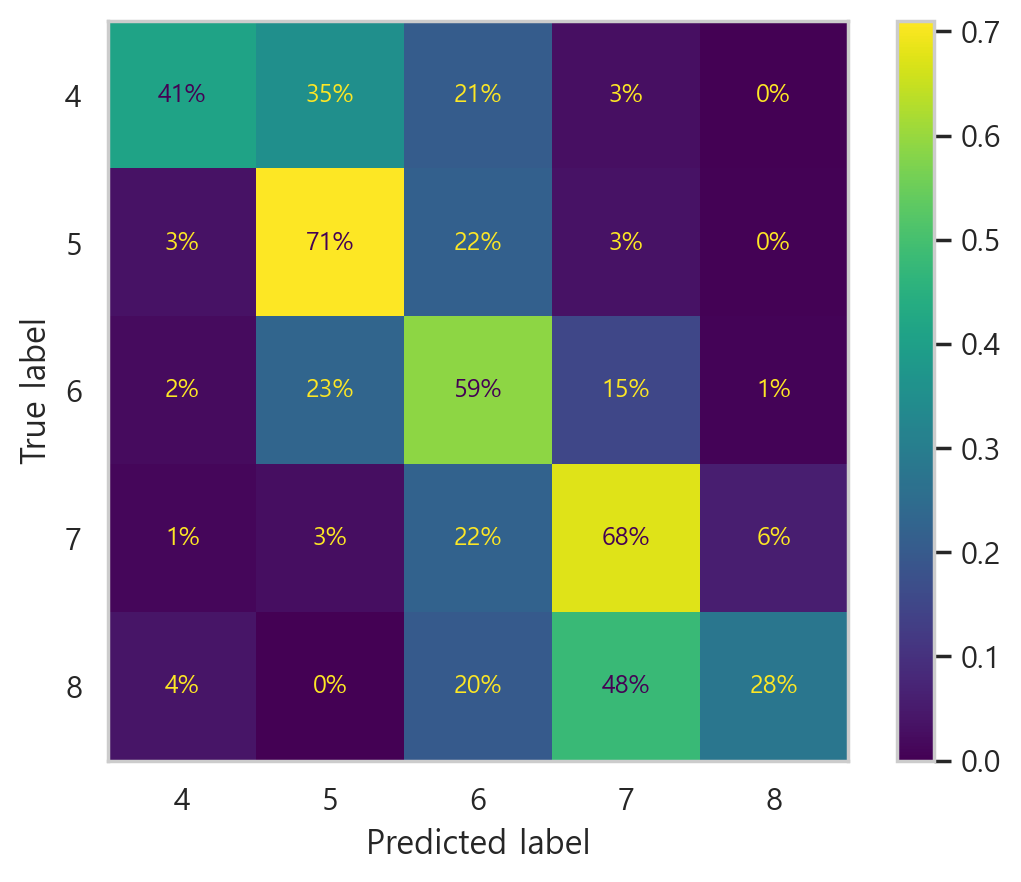

In [69]:
# 혼동행렬로 시각화

from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=9)  # 추가 코드 - 폰트 크기를 줄입니다
ConfusionMatrixDisplay.from_predictions(validset_labels, valid_pred1, normalize="true", values_format=".0%").ax_.grid(False)
plt.show()

## svm

In [ ]:
full_pipe = Pipeline([
    ("svm_clf", SVC(random_state=42, kernel="poly"))
])

# 파라미터 그리드 정의
param_grid = [{
    'smote__k_neighbors': [2,3,5,8],
    'svm_clf__degree': range(1,8),
    'svm_clf__C': [15,20,25,50,75],
    'svm_clf__coef0' : [1]
}]


# GridSearchCV 생성
grid_search = GridSearchCV(full_pipe, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

# GridSearchCV 수행
grid_search.fit(trainset, trainset_labels)

# 최적의 하이퍼파라미터와 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.2f}".format(grid_search.best_score_))

# 최적의 모델로 테스트 세트 예측
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 252 candidates, totalling 756 fits
Best parameters found:  {'smote__k_neighbors': 3, 'svm_clf__C': 50, 'svm_clf__coef0': 1, 'svm_clf__degree': 6}
Best cross-validation F1 score: 0.57


In [ ]:
# in test set

smote = SMOTE(random_state=42, k_neighbors=3)
X_train_over, y_train_over =  smote.fit_resample(trainset, trainset_labels)


svm_clf = SVC(random_state= 42, C=50, degree=5, coef0 = 1)

svm_clf.fit(X_train_over, y_train_over)

SVC(C=50, coef0=1, degree=5, random_state=42)

In [ ]:
# 첫 번째가 맞았는지 보자

first_wine = X_train_over.iloc[0]
first_wine= first_wine.values.reshape(1, -1) # 데이터프레임에서 제 1행 뽑은 시리즈이기 때문에, 어레이 형태로 바꿔줌


svm_clf.predict(first_wine)



c:\Users\zezeg\.conda\envs\datavisual\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=int64)

In [ ]:
y_train_over.iloc[0]

# 맞은 것 같음

5

In [ ]:
# 성능 평가 함수
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


train_pred = svm_clf.predict(X_train_over)


# 정확도, F1 점수, 정밀도, 재현율 계산
accuracy = accuracy_score(y_train_over, train_pred)
f1 = f1_score(y_train_over, train_pred, average='weighted')
precision = precision_score(y_train_over, train_pred, average='weighted')
recall = recall_score(y_train_over, train_pred, average='weighted')

# 결과를 딕셔너리로 저장
results_dict = {
    'Accuracy': [accuracy],
    'F1 Score': [f1],
    'Precision': [precision],
    'Recall': [recall]
}

# 데이터프레임으로 변환
results = pd.DataFrame(results_dict)

# 결과 출력
print(results)

   Accuracy  F1 Score  Precision  Recall
0      0.86      0.85       0.85    0.86


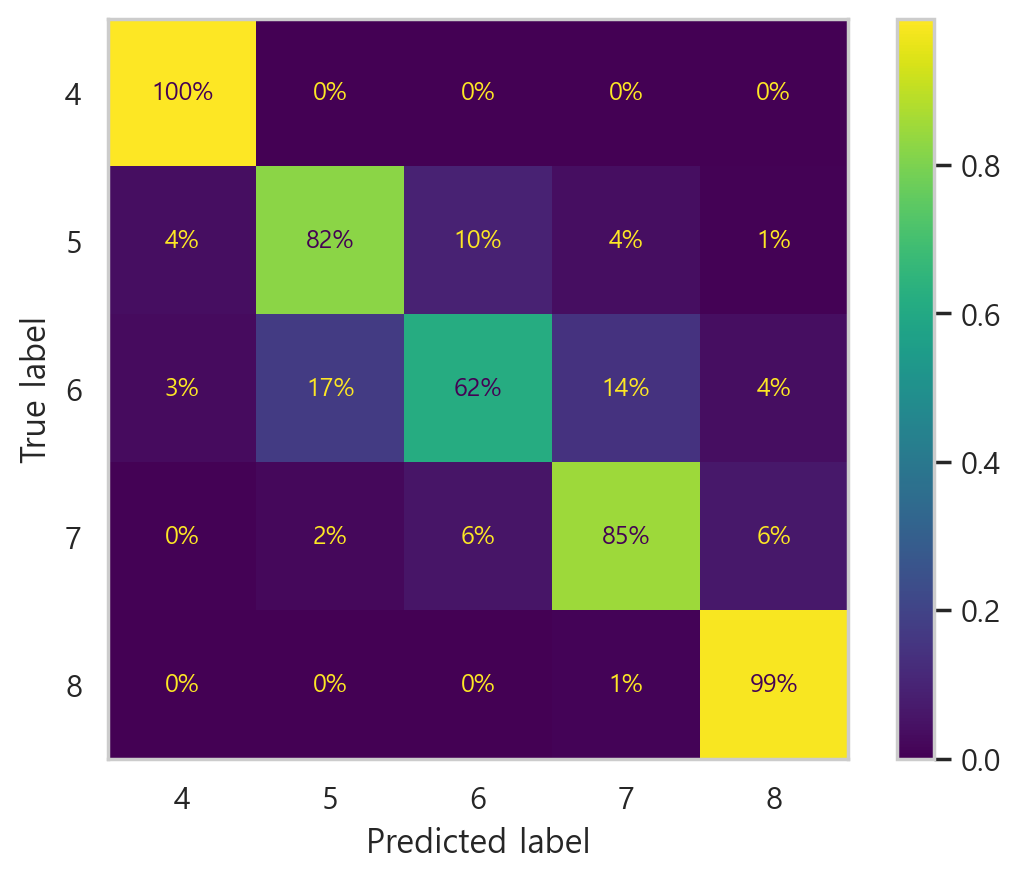

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=9)  # 추가 코드 - 폰트 크기를 줄입니다
ConfusionMatrixDisplay.from_predictions(y_train_over, train_pred, normalize="true", values_format=".0%").ax_.grid(False)
plt.show()

In [ ]:
# TRAIN과 TESTSET에서 SVM 성능 비교

import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# 예측 결과
train_pred = svm_clf.predict(X_train_over)
valid_pred1 = svm_clf.predict(validset1)

# 훈련 데이터에서의 성능 계산
train_accuracy = accuracy_score(y_train_over, train_pred)
train_f1 = f1_score(y_train_over, train_pred, average='weighted')
train_precision = precision_score(y_train_over, train_pred, average='weighted')
train_recall = recall_score(y_train_over, train_pred, average='weighted')


# 검증 데이터에서의 성능 계산
valid_accuracy = accuracy_score(validset_labels, valid_pred1)
valid_f1 = f1_score(validset_labels, valid_pred1, average='weighted')
valid_precision = precision_score(validset_labels, valid_pred1, average='weighted')
valid_recall = recall_score(validset_labels, valid_pred1, average='weighted')


# 성능 결과를 딕셔너리로 저장
results_dict = {
    'Metric': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'Train Score': [train_accuracy, train_f1, train_precision, train_recall],
    'Test Score': [valid_accuracy, valid_f1, valid_precision, valid_recall]
}

# 데이터프레임으로 변환
results = pd.DataFrame(results_dict)

# 결과 출력
print(results)




      Metric  Train Score  Test Score
0   Accuracy         0.86        0.50
1   F1 Score         0.85        0.50
2  Precision         0.85        0.52
3     Recall         0.86        0.50


과적합인게 보임

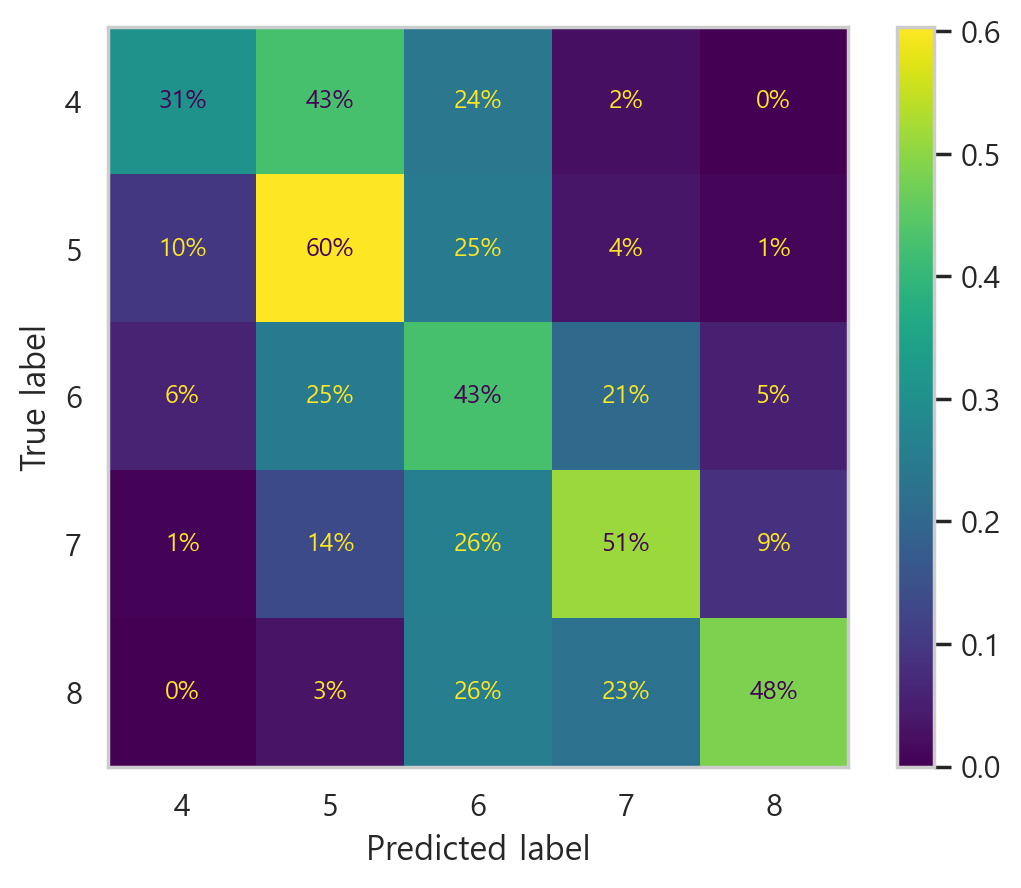

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=9)  # 추가 코드 - 폰트 크기를 줄입니다
ConfusionMatrixDisplay.from_predictions(validset_labels, valid_pred1, normalize="true", values_format=".0%").ax_.grid(False)
plt.show()

In [ ]:
full_pipe = Pipeline([
    ("svm_clf2", SVC(random_state=42, kernel="rbf"))
])

# 파라미터 그리드 정의
param_grid = [{
    'svm_clf2__C': [0.05,0.5,5],
    'svm_clf2__gamma' : [0.1,0.5,1,5]
}]


# GridSearchCV 생성
grid_search = GridSearchCV(full_pipe, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)

# GridSearchCV 수행
grid_search.fit(trainset, trainset_labels)

# 최적의 하이퍼파라미터와 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation F1 score: {:.2f}".format(grid_search.best_score_))

# 최적의 모델로 테스트 세트 예측
best_model = grid_search.best_estimator_

In [71]:
testset

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
5221           6.50              0.52         0.11            1.80       0.07   
2628           6.30              0.30         0.20            3.70       0.04   
3115           5.70              0.22         0.22           16.65       0.04   
17             6.50              0.28         0.25            4.80       0.03   
...             ...               ...          ...             ...        ...   
1462           6.20              0.56         0.09            1.70       0.05   
4415           8.10              0.19         0.40            0.90       0.04   
4525           7.40              0.16         0.49            1.20       0.06   
5083           7.50              0.33         0.36            2.60       0.05   

      free sulfur dioxide  total sulfur dioxide  density   pH  sulphates  \
5221                13.00                 38.00     1.00 3.34       0.52   
2628                34.00                132.00     0.99 3.00       0.38   
3115                39.00                110.00     1.00 3.24       0.48   
17                  54.00                128.00     0.99 3.17       0.44   
...                   ...                   ...      ...  ...        ...   
1462                24.00                 32.00     0.99 3.54       0.60   
4415                73.00                180.00     0.99 3.06       0.34   
4525                18.00                150.00     0.99 3.23       0.47   
5083                26.00                126.00     0.99 3.32       0.53   

      alcohol   type  
5221     9.30    red  
2628    10.70  white  
3115     9.00  white  
17      12.20  white  
...       ...    ...  
1462    11.30    red  
4415    10.00  white  
4525    11.20  white  
5083    12.70  white  

[1100 rows x 12 columns]

In [79]:

testset1 = preprocessing.transform(testset)

names = ["type_red", "type_white","citric acid", "alcohol", "chlorides", "free sulfur dioxide", "total sulfur dioxide","residual sugar", "fixed acidity", "volatile acidity", "density", "sulphates", "pH" ]

testset1 = pd.DataFrame(testset1, columns=names)

testset1 = testset1.drop(columns="type_white")

testset1

type_red  citric acid  alcohol  chlorides  free sulfur dioxide  \
0         1.00        -1.99    -1.08       1.23                -1.04   
1         0.00        -1.12     0.31      -0.58                 0.37   
2         0.00        -0.93    -1.45      -0.24                 0.65   
3         0.00        -0.65     1.35      -1.43                 1.38   
...        ...          ...      ...        ...                  ...   
1096      1.00        -2.18     0.77       0.30                -0.23   
1097      0.00         0.78    -0.32      -0.73                 2.19   
1098      0.00         1.63     0.69       0.41                -0.64   
1099      0.00         0.40     1.62       0.19                -0.10   

      total sulfur dioxide  residual sugar  fixed acidity  volatile acidity  \
0                    -1.40           -0.86           0.47              0.80   
1                     0.32            0.06           0.43              0.43   
2                    -0.07            1.70           0.30              0.29   
3                     0.25            0.37           0.47              0.40   
...                    ...             ...            ...               ...   
1096                 -1.52           -0.94           0.41              0.86   
1097                  1.14           -1.84           0.77              0.23   
1098                  0.63           -1.42           0.65              0.17   
1099                  0.21           -0.38           0.66              0.49   

      density  sulphates   pH  
0        0.50       0.53 0.67  
1        0.26       0.30 0.26  
2        0.68       0.46 0.55  
3        0.20       0.40 0.47  
...       ...        ...  ...  
1096     0.41       0.65 0.90  
1097     0.32       0.23 0.34  
1098     0.26       0.45 0.54  
1099     0.22       0.54 0.65  

[1100 rows x 12 columns]